## Load Ground Truth and Model

In [ ]:
# transformer_testing.py
import os, sys, json
import joblib
import numpy as np
import pandas as pd
import gseapy as gp
import torch
import torch.nn.functional as F
import random

from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from matplotlib.ticker import FuncFormatter, MultipleLocator
from re import sub
from tqdm import tqdm
from sklearn.metrics import r2_score
import logging
import matplotlib.pyplot as plt

import sys
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from datetime import datetime
from config.settings_hpc import *

logging.basicConfig(level=logging.INFO, format='%(message)s')

# ---------------------------------------------------------------------
# Paths / config
# ---------------------------------------------------------------------


from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset import MultiChromosomeDataset, SimpleScaler, fit_simple_scalers

experiment = "no_classifier_head"
output_dir = Path(PROJECT_DIR) / "experiments" / "mESC_no_scale_linear" #/ "chr19"
SELECTED_EXPERIMENT_DIR = output_dir / experiment

tf_emb_file = "tf_tg_embeddings_final.pt"

gpu_log_file = Path(PROJECT_DIR) / "LOGS" / "transformer_logs" / "03_training" / "gpu_usage_transformer_training_3413062.20251116_104037.csv"

# Load Ground Truth DataFrame
GROUND_TRUTH_DIR = os.path.join(PROJECT_DIR, "data/ground_truth_files")

# GROUND_TRUTH_FILE = os.path.join(GROUND_TRUTH_DIR, "combined_ground_truth.csv")
GROUND_TRUTH_FILE = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.GRN_BENCHMARKING.MOELLER/testing_bear_grn/GROUND.TRUTHS/filtered_RN111_and_RN112_mESC_E7.5_rep1.tsv"

if GROUND_TRUTH_FILE.endswith(".csv"):
    sep = ","
elif GROUND_TRUTH_FILE.endswith(".tsv"):
    sep="\t"
    
ground_truth_df = pd.read_csv(GROUND_TRUTH_FILE, sep=sep)
if GROUND_TRUTH_FILE == os.path.join(GROUND_TRUTH_DIR, "chip_atlas_tf_peak_tg_dist.csv"):
    ground_truth_df = ground_truth_df[["source_id", "target_id"]]

ground_truth_df = ground_truth_df.rename(columns={ground_truth_df.columns[0]: "tf", ground_truth_df.columns[1]: "tg"})
ground_truth_df["tf"] = ground_truth_df["tf"].astype(str).str.upper()
ground_truth_df["tg"] = ground_truth_df["tg"].astype(str).str.upper()
print(ground_truth_df.head())

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH  = 32
TG_CHUNK = 64

      tf    tg
0   AFF3  XKR4
1  BTAF1  XKR4
2   CBX7  XKR4
3   CDK8  XKR4
4   CTCF  XKR4


## TG Expression Prediction

In [2]:
def nanaware_per_gene_stats(y_true, y_pred, eps=1e-8):
    """Compute per-gene metrics accounting for NaN entries."""
    N, G = y_true.shape
    r2 = np.full(G, np.nan, dtype=np.float64)
    pearson = np.full(G, np.nan, dtype=np.float64)
    mae = np.full(G, np.nan, dtype=np.float64)
    rmse = np.full(G, np.nan, dtype=np.float64)
    n_obs = np.zeros(G, dtype=np.int32)

    for j in range(G):
        mask = np.isfinite(y_true[:, j]) & np.isfinite(y_pred[:, j])
        m = mask.sum()
        n_obs[j] = m
        
        if m < 2:
            continue
            
        yt = y_true[mask, j].astype(np.float64)
        yp = y_pred[mask, j].astype(np.float64)

        diff = yt - yp
        mae[j] = np.mean(np.abs(diff))
        rmse[j] = np.sqrt(np.mean(diff**2))

        yt_c = yt - yt.mean()
        yp_c = yp - yp.mean()
        yt_std = np.sqrt((yt_c**2).sum())
        yp_std = np.sqrt((yp_c**2).sum())
        if yt_std > 0 and yp_std > 0:
            pearson[j] = (yt_c @ yp_c) / (yt_std * yp_std)

        sst = ((yt - yt.mean())**2).sum()
        sse = (diff**2).sum()
        r2[j] = 1.0 - sse / (sst + eps)

    return {"r2": r2, "pearson": pearson, "mae": mae, "rmse": rmse, "n_obs": n_obs}

### Load Model

In [3]:
from tabnanny import check


def load_model(checkpoint_file, device):
    # 1) Load test loader and checkpoint
    test_loader = torch.load(SELECTED_EXPERIMENT_DIR / "test_loader.pt", weights_only=False)

    ckpt_path = os.path.join(SELECTED_EXPERIMENT_DIR, checkpoint_file)
    state = torch.load(ckpt_path, map_location="cpu")

    # 2) Recreate model EXACTLY as in training
    model = MultiomicTransformer(
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        d_ff=D_FF,
        dropout=DROPOUT,
        tf_vocab_size=len(state["tf_scaler_mean"]),
        tg_vocab_size=len(state["tg_scaler_mean"]),
        use_bias=USE_DISTANCE_BIAS,
        use_shortcut=USE_SHORTCUT,
        use_motif_mask=USE_MOTIF_MASK,
        use_edge_head=True,
        edge_extra_dim=0,
        edge_hidden_dim=128,
    )

    if isinstance(state, dict) and "model_state_dict" in state:
        model.load_state_dict(state["model_state_dict"])
    else:
        model.load_state_dict(state)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # 3) Rebuild scalers on the SAME DEVICE as inputs
    tg_scaler = SimpleScaler(
        mean=torch.as_tensor(state["tg_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tg_scaler_std"],  device=device, dtype=torch.float32),
    )
    tf_scaler = SimpleScaler(
        mean=torch.as_tensor(state["tf_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tf_scaler_std"],  device=device, dtype=torch.float32),
    )

    return model, test_loader, tg_scaler, tf_scaler

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model, test_loader, tg_scaler, tf_scaler = load_model("trained_model.pt", device)

### Plot Final Pred vs Obs TG Expr

Evaluating on test set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [00:41<00:00,  8.23batches/s]


Per-gene R² stats (ignoring NaNs / near-constant genes):
  mean   : 0.517523486961737
  median : 0.7593834904241942
  std    : 11.9472496955746

SCATTER PLOT STATISTICS
Overall R² (from all points): 0.8930
N samples (valid points): 3,864,492
Prediction range: [0.0000, 6.2116]
Target range:     [-0.0000, 5.4242]
Median per-gene R²: 0.7594


/tmp/ipykernel_3762917/1792267516.py:147: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3762917/1792267516.py:148: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(SELECTED_EXPERIMENT_DIR / "test_set_r2_distribution.png", dpi=300)
/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


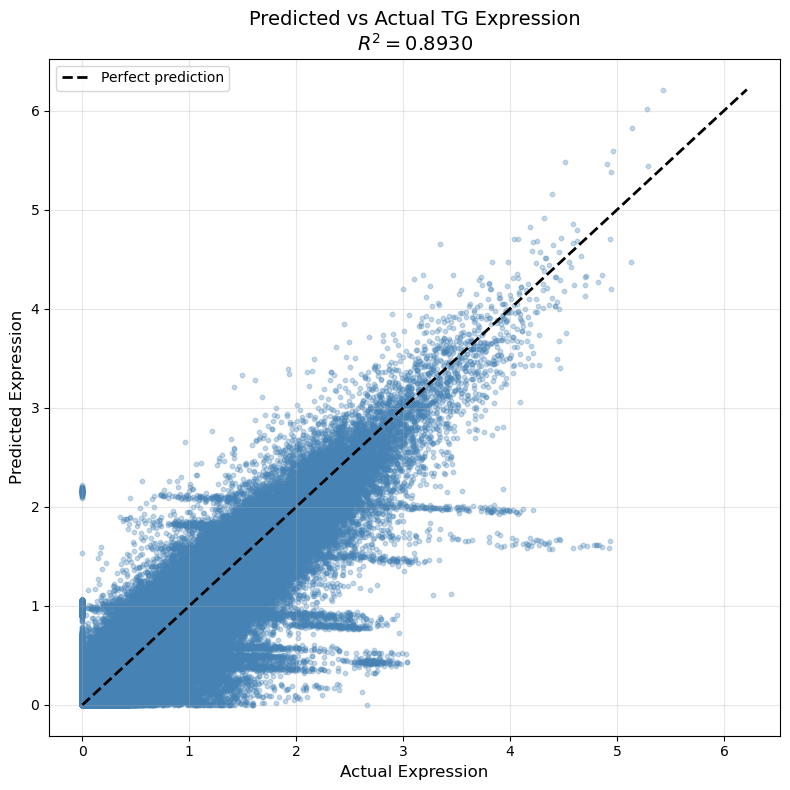

In [4]:

G_total = tg_scaler.mean.shape[0]  # total number of genes

# ---- global per-gene accumulators (unscaled space) ----
sse_g   = torch.zeros(G_total, dtype=torch.float64)
sumy_g  = torch.zeros(G_total, dtype=torch.float64)
sumy2_g = torch.zeros(G_total, dtype=torch.float64)
cnt_g   = torch.zeros(G_total, dtype=torch.float64)

### For overall R² and scatter:
all_preds_for_plot = []
all_tgts_for_plot  = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating on test set", unit="batches")):
        atac_wins, tf_tensor, targets, bias, tf_ids, tg_ids, motif_mask = batch
        atac_wins  = atac_wins.to(device)
        tf_tensor  = tf_tensor.to(device)
        targets    = targets.to(device)
        bias       = bias.to(device)
        tf_ids     = tf_ids.to(device)
        tg_ids     = tg_ids.to(device)
        motif_mask = motif_mask.to(device)

        # scale / predict exactly like in validation
        if tf_scaler is not None:
            tf_tensor = tf_scaler.transform(tf_tensor, tf_ids)
        if tg_scaler is not None:
            targets_s = tg_scaler.transform(targets, tg_ids)
        else:
            targets_s = targets

        preds_s, _, _, _ = model(
            atac_wins, tf_tensor,
            tf_ids=tf_ids, tg_ids=tg_ids,
            bias=bias, motif_mask=motif_mask,
            return_edge_logits=True, return_shortcut_contrib=False,
            edge_extra_features=None,
        )

        preds_s   = torch.nan_to_num(preds_s.float(),   nan=0.0, posinf=1e6, neginf=-1e6)
        targets_s = torch.nan_to_num(targets_s.float(), nan=0.0, posinf=1e6, neginf=-1e6)

        # unscale + clamp
        if tg_scaler is not None:
            targets_u = tg_scaler.inverse_transform(targets_s, tg_ids)
            preds_u   = tg_scaler.inverse_transform(preds_s,   tg_ids)
        else:
            targets_u, preds_u = targets_s, preds_s

        targets_u = torch.nan_to_num(targets_u.float(), nan=0.0, posinf=1e6, neginf=-1e6)
        preds_u   = torch.nan_to_num(preds_u.float(),   nan=0.0, posinf=1e6, neginf=-1e6)
        preds_u   = preds_u.clamp_min(0.0)

        # ---- store for overall R² / scatter ----
        all_tgts_for_plot.append(targets_u.detach().cpu().numpy())
        all_preds_for_plot.append(preds_u.detach().cpu().numpy())

        # ---- per-gene accumulators (unscaled) ----
        # shapes: [B, G_eval]
        err2   = (targets_u - preds_u) ** 2
        B      = targets_u.shape[0]

        # reduce over batch
        sse_batch   = err2.sum(dim=0)              # [G_eval]
        sumy_batch  = targets_u.sum(dim=0)
        sumy2_batch = (targets_u ** 2).sum(dim=0)
        cnt_batch   = torch.full_like(sse_batch, B, dtype=torch.float64)

        # move ids to CPU, accumulate into global vectors
        ids_cpu = tg_ids.cpu()
        sse_g.index_add_(0, ids_cpu, sse_batch.cpu().to(torch.float64))
        sumy_g.index_add_(0, ids_cpu, sumy_batch.cpu().to(torch.float64))
        sumy2_g.index_add_(0, ids_cpu, sumy2_batch.cpu().to(torch.float64))
        cnt_g.index_add_(0, ids_cpu, cnt_batch.cpu().to(torch.float64))

# ============================
# 4) Per-gene R² (global)
# ============================
eps = 1e-12
mask = cnt_g > 0  # genes that appeared in the test set

mean_g = sumy_g[mask] / cnt_g[mask]
sst_g  = sumy2_g[mask] - cnt_g[mask] * (mean_g ** 2)

valid = sst_g > eps  # genes with non-trivial variance

r2_g = torch.full_like(sse_g, float("nan"), dtype=torch.float64)

idx_all  = mask.nonzero(as_tuple=True)[0]   # indices of genes with any data
idx_keep = idx_all[valid]                   # subset with non-zero variance

r2_g_values = 1.0 - (sse_g[idx_keep] / torch.clamp(sst_g[valid], min=eps))
r2_g[idx_keep] = r2_g_values

r2_g_cpu = r2_g.cpu().numpy()
mean_r2_gene   = np.nanmean(r2_g_cpu)
median_r2_gene = np.nanmedian(r2_g_cpu)
std_r2_gene    = np.nanstd(r2_g_cpu)

print("Per-gene R² stats (ignoring NaNs / near-constant genes):")
print("  mean   :", mean_r2_gene)
print("  median :", median_r2_gene)
print("  std    :", std_r2_gene)

# ============================
# 5) Global R² + scatter plot
# ============================
preds_flat = np.concatenate([p.reshape(-1) for p in all_preds_for_plot])
tgts_flat  = np.concatenate([t.reshape(-1) for t in all_tgts_for_plot])

# Remove NaNs / infs
valid = np.isfinite(preds_flat) & np.isfinite(tgts_flat)
preds_clean = preds_flat[valid]
tgts_clean  = tgts_flat[valid]

# Overall R² across all points
r2_overall = r2_score(tgts_clean, preds_clean)

print("\n" + "="*60)
print("SCATTER PLOT STATISTICS")
print("="*60)
print(f"Overall R² (from all points): {r2_overall:.4f}")
print(f"N samples (valid points): {len(preds_clean):,}")
print(f"Prediction range: [{np.min(preds_clean):.4f}, {np.max(preds_clean):.4f}]")
print(f"Target range:     [{np.min(tgts_clean):.4f}, {np.max(tgts_clean):.4f}]")
print(f"Median per-gene R²: {median_r2_gene:.4f}")

# ---- scatter plot ----
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tgts_clean, preds_clean, alpha=0.3, s=10, color='steelblue')

lims = [
    min(np.min(tgts_clean), np.min(preds_clean)),
    max(np.max(tgts_clean), np.max(preds_clean))
]
ax.plot(lims, lims, 'k--', lw=2, label='Perfect prediction')

ax.set_xlabel('Actual Expression', fontsize=12)
ax.set_ylabel('Predicted Expression', fontsize=12)
ax.set_title(
    "Predicted vs Actual TG Expression\n"
    f"$R^2 = {r2_overall:.4f}$",
    fontsize=14,
)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "test_set_r2_distribution.png", dpi=300)
plt.show()


### Plot Pred vs Obs TG Expr across Chkpts

Found checkpoints: [0, 5, 10, 20, 30, 40, 50, 60, 70, 90, 100, 120, 135]

Evaluating checkpoint_0.pt ...
Checkpoint checkpoint_0.pt:
  Global R²      : -10.5174
  Mean gene R²   : -60.6938
  Median gene R² : -0.7346

Evaluating checkpoint_5.pt ...
Checkpoint checkpoint_5.pt:
  Global R²      : 0.4740
  Mean gene R²   : -0.1212
  Median gene R² : -0.0421

Evaluating checkpoint_10.pt ...
Checkpoint checkpoint_10.pt:
  Global R²      : 0.4665
  Mean gene R²   : -0.1333
  Median gene R² : -0.0422

Evaluating checkpoint_20.pt ...
Checkpoint checkpoint_20.pt:
  Global R²      : 0.5966
  Mean gene R²   : 0.0705
  Median gene R² : 0.1292

Evaluating checkpoint_30.pt ...
Checkpoint checkpoint_30.pt:
  Global R²      : 0.6731
  Mean gene R²   : 0.1617
  Median gene R² : 0.3116

Evaluating checkpoint_40.pt ...
Checkpoint checkpoint_40.pt:
  Global R²      : 0.7246
  Mean gene R²   : 0.2966
  Median gene R² : 0.3818

Evaluating checkpoint_50.pt ...
Checkpoint checkpoint_50.pt:
  Global R²      : 0

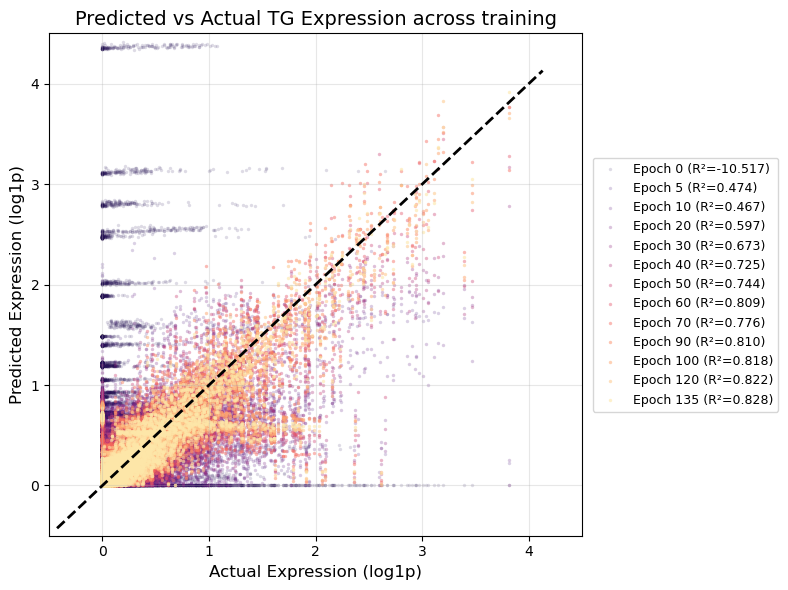

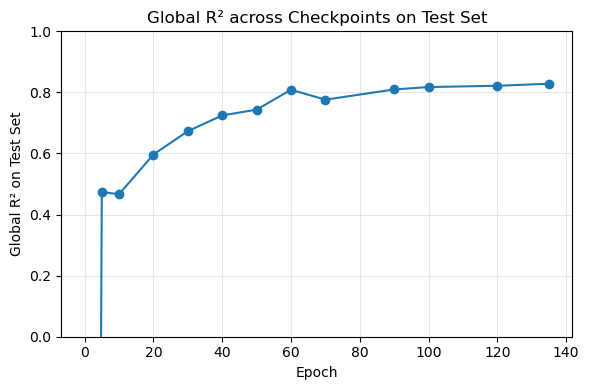

In [5]:
# ============================================================
# Evaluate multiple checkpoints and overlay Pred vs Actual plots
# ============================================================
import os, re, gc
import numpy as np
import torch
import matplotlib.pyplot as plt

# -------- CONFIG --------
CKPT_DIR = SELECTED_EXPERIMENT_DIR          # directory with checkpoint_*.pt
CKPT_GLOB_PREFIX = "checkpoint_"
CKPT_EXT = ".pt"

# If you want to select specific epochs, set this to a sorted list.
EPOCHS_TO_PLOT = [0, 5, 10, 20, 30, 40, 50, 60, 70, 90, 100, 120, 135]

# Evaluation controls
NUM_TGS_SUBSET = 200        # number of TGs to evaluate per batch
TG_BATCH_SIZE = 50          # chunked over genes
NUM_BATCHES_TO_EVAL = 5     # first N batches from test_loader
MAX_POINTS_TO_PLOT = 150_000

# Plot look
FIGSIZE = (8, 6)
CMAP = plt.cm.magma
BASE_ALPHA = 0.15
MAX_ALPHA  = 0.60
MARKER_SIZE = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def parse_epoch_from_filename(fname: str):
    m = re.search(rf"{CKPT_GLOB_PREFIX}(\d+){re.escape(CKPT_EXT)}$", fname)
    return int(m.group(1)) if m else None


def list_checkpoints(ckpt_dir):
    files = []
    for f in os.listdir(ckpt_dir):
        if f.startswith(CKPT_GLOB_PREFIX) and f.endswith(CKPT_EXT):
            ep = parse_epoch_from_filename(f)
            if ep is not None:
                files.append((ep, os.path.join(ckpt_dir, f)))
    files.sort(key=lambda x: x[0])
    if EPOCHS_TO_PLOT is not None:
        keep = set(EPOCHS_TO_PLOT)
        files = [(ep, p) for ep, p in files if ep in keep]
        files.sort(key=lambda x: x[0])
    return files


def evaluate_checkpoint(ckpt_path: str):
    """
    Returns:
      preds_np        : [N_cells, N_genes_subset] unscaled preds (log1p, clamped >=0)
      tgts_np         : [N_cells, N_genes_subset] unscaled targets (log1p)
      r2_global       : global R² over all evaluated points
      mean_r2_gene    : mean per-gene R²
      median_r2_gene  : median per-gene R²
    """
    # Load state
    state = torch.load(ckpt_path, map_location="cpu")

    # Recreate the model with the same hyperparams
    model = MultiomicTransformer(
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        d_ff=D_FF,
        dropout=DROPOUT,
        tf_vocab_size=len(state["tf_scaler_mean"]),
        tg_vocab_size=len(state["tg_scaler_mean"]),
        use_bias=USE_DISTANCE_BIAS,
        use_shortcut=USE_SHORTCUT,
        use_motif_mask=USE_MOTIF_MASK,
        use_edge_head=True,
        edge_extra_dim=0,
        edge_hidden_dim=128,
    )
    model.load_state_dict(
        state["model_state_dict"] if isinstance(state, dict) and "model_state_dict" in state else state
    )
    model.to(device).eval()

    # Scalers on device
    tf_scaler = SimpleScaler(
        mean=torch.as_tensor(state["tf_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tf_scaler_std"],  device=device, dtype=torch.float32),
    )
    tg_scaler = SimpleScaler(
        mean=torch.as_tensor(state["tg_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tg_scaler_std"],  device=device, dtype=torch.float32),
    )

    G_total = tg_scaler.mean.shape[0]

    # per-gene accumulators (unscaled, log1p space)
    sse_g   = torch.zeros(G_total, dtype=torch.float64)
    sumy_g  = torch.zeros(G_total, dtype=torch.float64)
    sumy2_g = torch.zeros(G_total, dtype=torch.float64)
    cnt_g   = torch.zeros(G_total, dtype=torch.float64)

    preds_all = []
    tgts_all  = []

    use_amp = (device.type == "cuda")
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if NUM_BATCHES_TO_EVAL is not None and batch_idx >= NUM_BATCHES_TO_EVAL:
                break

            atac, tf, tg_target, bias, tf_ids, tg_ids, motif = batch

            # move everything the model uses to device
            atac      = atac.to(device, non_blocking=True)
            tf        = tf.to(device, non_blocking=True)
            tg_target = tg_target.to(device, non_blocking=True)
            bias      = bias.to(device, non_blocking=True)
            motif     = motif.to(device, non_blocking=True)
            tf_ids    = tf_ids.to(device, non_blocking=True).long()
            tg_ids    = tg_ids.to(device, non_blocking=True).long()

            # scale TF as in training
            tf_scaled = tf_scaler.transform(tf, tf_ids)

            # ---- single forward pass over ALL TGs in this batch ----
            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                preds_s, _, _, _ = model(
                    atac, tf_scaled,
                    tf_ids=tf_ids, tg_ids=tg_ids,
                    bias=bias, motif_mask=motif,
                    return_edge_logits=True,
                    return_shortcut_contrib=False,
                    edge_extra_features=None,
                )

            preds_s = torch.nan_to_num(preds_s.float(), nan=0.0, posinf=1e6, neginf=-1e6)

            # optional subset of genes (to keep plotting / compute manageable)
            if NUM_TGS_SUBSET is not None:
                max_tgs = min(NUM_TGS_SUBSET, preds_s.shape[1])
                preds_s_sub   = preds_s[:, :max_tgs]
                tg_target_sub = tg_target[:, :max_tgs]
                tg_ids_sub    = tg_ids[:max_tgs]
            else:
                preds_s_sub   = preds_s
                tg_target_sub = tg_target
                tg_ids_sub    = tg_ids

            # inverse-transform to log1p space and clamp
            preds_u = tg_scaler.inverse_transform(preds_s_sub, tg_ids_sub)
            preds_u = torch.nan_to_num(preds_u.float(), nan=0.0, posinf=1e6, neginf=-1e6)
            preds_u = preds_u.clamp_min(0.0)

            preds_all.append(preds_u.cpu().numpy())
            tgts_all.append(tg_target_sub.cpu().numpy())

            # ------- per-gene accumulators -------
            err2 = (tg_target_sub - preds_u) ** 2
            B    = tg_target_sub.shape[0]

            sse_batch   = err2.sum(dim=0)              # [G_sub]
            sumy_batch  = tg_target_sub.sum(dim=0)
            sumy2_batch = (tg_target_sub ** 2).sum(dim=0)
            cnt_batch   = torch.full_like(sse_batch, B, dtype=torch.float64)

            ids_cpu = tg_ids_sub.cpu()
            sse_g.index_add_(0, ids_cpu, sse_batch.detach().cpu().to(torch.float64))
            sumy_g.index_add_(0, ids_cpu, sumy_batch.detach().cpu().to(torch.float64))
            sumy2_g.index_add_(0, ids_cpu, sumy2_batch.detach().cpu().to(torch.float64))
            cnt_g.index_add_(0, ids_cpu, cnt_batch.detach().cpu().to(torch.float64))

    # ---- arrays for plotting / global R² ----
    preds_np = np.concatenate(preds_all, axis=0)
    tgts_np  = np.concatenate(tgts_all, axis=0)

    pf = preds_np.ravel()
    tfv = tgts_np.ravel()
    valid = np.isfinite(pf) & np.isfinite(tfv)

    if valid.sum() < 2 or np.allclose(tfv[valid], tfv[valid].mean()):
        r2_global = np.nan
    else:
        ss_res = np.sum((tfv[valid] - pf[valid]) ** 2)
        ss_tot = np.sum((tfv[valid] - tfv[valid].mean()) ** 2)
        r2_global = 1.0 - (ss_res / (ss_tot + 1e-12))

    # ---- per-gene R² ----
    eps = 1e-12
    mask = cnt_g > 0

    mean_g = sumy_g[mask] / cnt_g[mask]
    sst_g  = sumy2_g[mask] - cnt_g[mask] * (mean_g ** 2)

    valid_var = sst_g > eps
    r2_g = torch.full_like(sse_g, float("nan"), dtype=torch.float64)

    idx_all  = mask.nonzero(as_tuple=True)[0]
    idx_keep = idx_all[valid_var]

    r2_vals = 1.0 - (sse_g[idx_keep] / torch.clamp(sst_g[valid_var], min=eps))
    r2_g[idx_keep] = r2_vals

    r2_g_np = r2_g.cpu().numpy()
    mean_r2_gene   = float(np.nanmean(r2_g_np))
    median_r2_gene = float(np.nanmedian(r2_g_np))

    print(f"Checkpoint {os.path.basename(ckpt_path)}:")
    print(f"  Global R²      : {r2_global:.4f}")
    print(f"  Mean gene R²   : {mean_r2_gene:.4f}")
    print(f"  Median gene R² : {median_r2_gene:.4f}")

    del model, state, tf_scaler, tg_scaler
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    return preds_np, tgts_np, r2_global, mean_r2_gene, median_r2_gene


# ---------- Run across checkpoints ----------
ckpts = list_checkpoints(CKPT_DIR)
if len(ckpts) == 0:
    raise FileNotFoundError(
        f"No checkpoints found under {CKPT_DIR} matching pattern {CKPT_GLOB_PREFIX}*{CKPT_EXT}"
    )

print("Found checkpoints:", [ep for ep, _ in ckpts])

all_layers = []  # each: {"epoch", "preds", "tgts", "r2", "median_r2_gene"}
for ep, path in ckpts:
    print(f"\nEvaluating {os.path.basename(path)} ...")
    preds_np, tgts_np, r2_global, mean_r2_gene, median_r2_gene = evaluate_checkpoint(path)
    all_layers.append(
        {
            "epoch": ep,
            "preds": preds_np,
            "tgts": tgts_np,
            "r2": r2_global,
            "median_r2_gene": median_r2_gene,
        }
    )

# ---------- Plot overlay ----------
fig, ax = plt.subplots(figsize=FIGSIZE)

# Collect all values to set common limits
all_targets = np.concatenate([L["tgts"].ravel() for L in all_layers])
all_preds   = np.concatenate([L["preds"].ravel() for L in all_layers])
valid_all   = np.isfinite(all_targets) & np.isfinite(all_preds)

low  = np.nanpercentile(np.concatenate([all_targets[valid_all], all_preds[valid_all]]), 0.5)
high = np.nanpercentile(np.concatenate([all_targets[valid_all], all_preds[valid_all]]), 99.5)
rng  = high - low
pad  = 0.25 * rng
lims = [low - pad, high + pad + 2]

# Sort by epoch so older checkpoints plot first
all_layers.sort(key=lambda d: d["epoch"])
n_ckpts   = len(all_layers)
positions = np.linspace(0.15, 0.95, n_ckpts)  # color positions in colormap

for i, layer in enumerate(all_layers):
    ep    = layer["epoch"]
    preds = layer["preds"].ravel()
    tgts  = layer["tgts"].ravel()
    valid = np.isfinite(preds) & np.isfinite(tgts)
    idx   = np.where(valid)[0]

    # Downsample for readability
    if len(idx) > MAX_POINTS_TO_PLOT:
        rng_ds = np.random.default_rng(1234 + i)
        idx = rng_ds.choice(idx, size=MAX_POINTS_TO_PLOT, replace=False)

    color = CMAP(positions[i])
    alpha = BASE_ALPHA + (MAX_ALPHA - BASE_ALPHA) * (i / max(1, n_ckpts - 1))

    ax.scatter(
        tgts[idx],
        preds[idx],
        s=MARKER_SIZE,
        c=[color],
        alpha=alpha,
        linewidths=0,
        label=f"Epoch {ep} (R²={layer['r2']:.3f})",
    )

# 1:1 line
ax.plot(lims, lims, linestyle="--", color="black", linewidth=2)

ax.set_xlabel("Actual Expression (log1p)", fontsize=12)
ax.set_ylabel("Predicted Expression (log1p)", fontsize=12)
ax.set_title("Predicted vs Actual TG Expression across training", fontsize=14)
ax.grid(alpha=0.3)
ax.set_ylim((-0.5, 4.5))
ax.set_xlim((-0.5, 4.5))
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # (x, y) in axes coords
    borderaxespad=0.0,
    fontsize=9,
    frameon=True,
)

plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "test_set_r2_distribution_across_checkpoints.png", dpi=300)
plt.show()

fig = plt.figure(figsize=(6,4))
r2_across_epochs = [L['r2'] for L in all_layers]
plt.plot([L['epoch'] for L in all_layers], r2_across_epochs, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Global R² on Test Set")
plt.title("Global R² across Checkpoints on Test Set")
plt.grid(alpha=0.3)
plt.ylim((0,1))
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "test_set_global_r2_across_checkpoints.png", dpi=300)
plt.show()


### Plot Prediction Trajectory

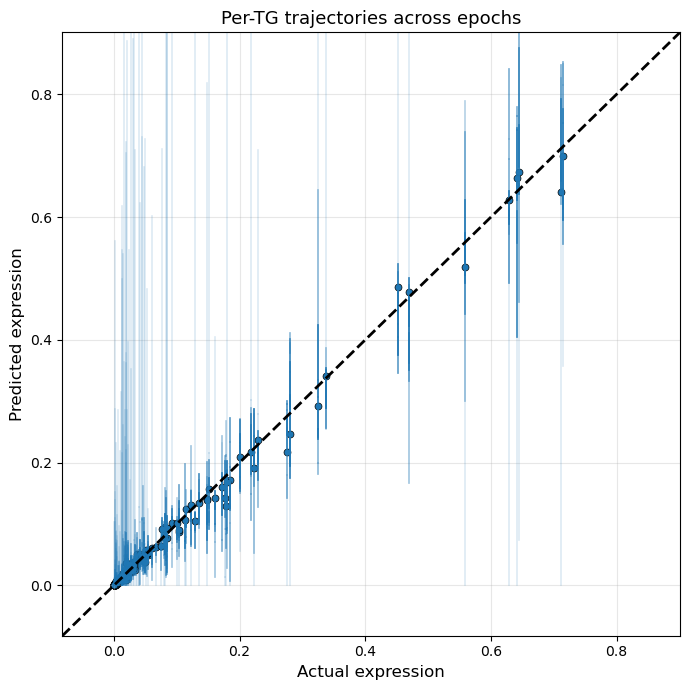

In [ ]:
# Number of genes (TGs) in your eval subset
n_tgs = all_layers[0]["preds"].shape[1]

# For each epoch: mean across samples for each TG
# shapes: [n_epochs, n_tgs]
mean_tgts = np.stack(
    [np.nanmean(layer["tgts"], axis=0) for layer in all_layers],
    axis=0
)
mean_preds = np.stack(
    [np.nanmean(layer["preds"], axis=0) for layer in all_layers],
    axis=0
)

fig, ax = plt.subplots(figsize=(7, 7))

n_epochs   = len(all_layers)
n_plot_tgs = n_tgs

# One shared color for all TG trajectories
traj_color = "tab:blue"

# Earlier epochs more transparent, later epochs more opaque
alpha_min, alpha_max = 0.10, 0.75
epoch_alphas = np.linspace(alpha_min, alpha_max, n_epochs)

# ---- Compute axis limits ONCE, outside the loop ----
all_x = mean_tgts[:, :n_plot_tgs].ravel()
all_y = mean_preds[:, :n_plot_tgs].ravel()
valid = np.isfinite(all_x) & np.isfinite(all_y)

low  = np.nanpercentile(np.concatenate([all_x[valid], all_y[valid]]), 1)
high = np.nanpercentile(np.concatenate([all_x[valid], all_y[valid]]), 99)
pad  = 0.1 * (high - low)
lims = [low - pad, high + pad]

ax.set_xlim(lims)
ax.set_ylim(lims)

# ---- Plot trajectories ----
for g in range(n_plot_tgs):
    x = mean_tgts[:, g]   # [n_epochs]
    y = mean_preds[:, g]  # [n_epochs]

    # Draw "tails": line segments between consecutive epochs
    for e in range(1, n_epochs):
        ax.plot(
            [x[e - 1], x[e]],
            [y[e - 1], y[e]],
            color=traj_color,
            alpha=epoch_alphas[e],   # later segments more opaque
            linewidth=1.2,
        )

    # Only draw a marker at the *latest* position
    ax.scatter(
        x[-1],
        y[-1],
        s=25,
        color=traj_color,
        alpha=1.0,
        edgecolors="black",
        linewidths=0.5,
    )

# 1:1 line
ax.plot(lims, lims, "--", color="black", linewidth=2)

ax.set_xlabel("Actual expression", fontsize=12)
ax.set_ylabel("Predicted expression", fontsize=12)
ax.set_title("Per-TG trajectories across epochs", fontsize=13)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "test_set_per_tg_trajectories_across_checkpoints.png", dpi=300)
plt.show()


## TF-TG Embedding Similarity

### Similarity Heatmap

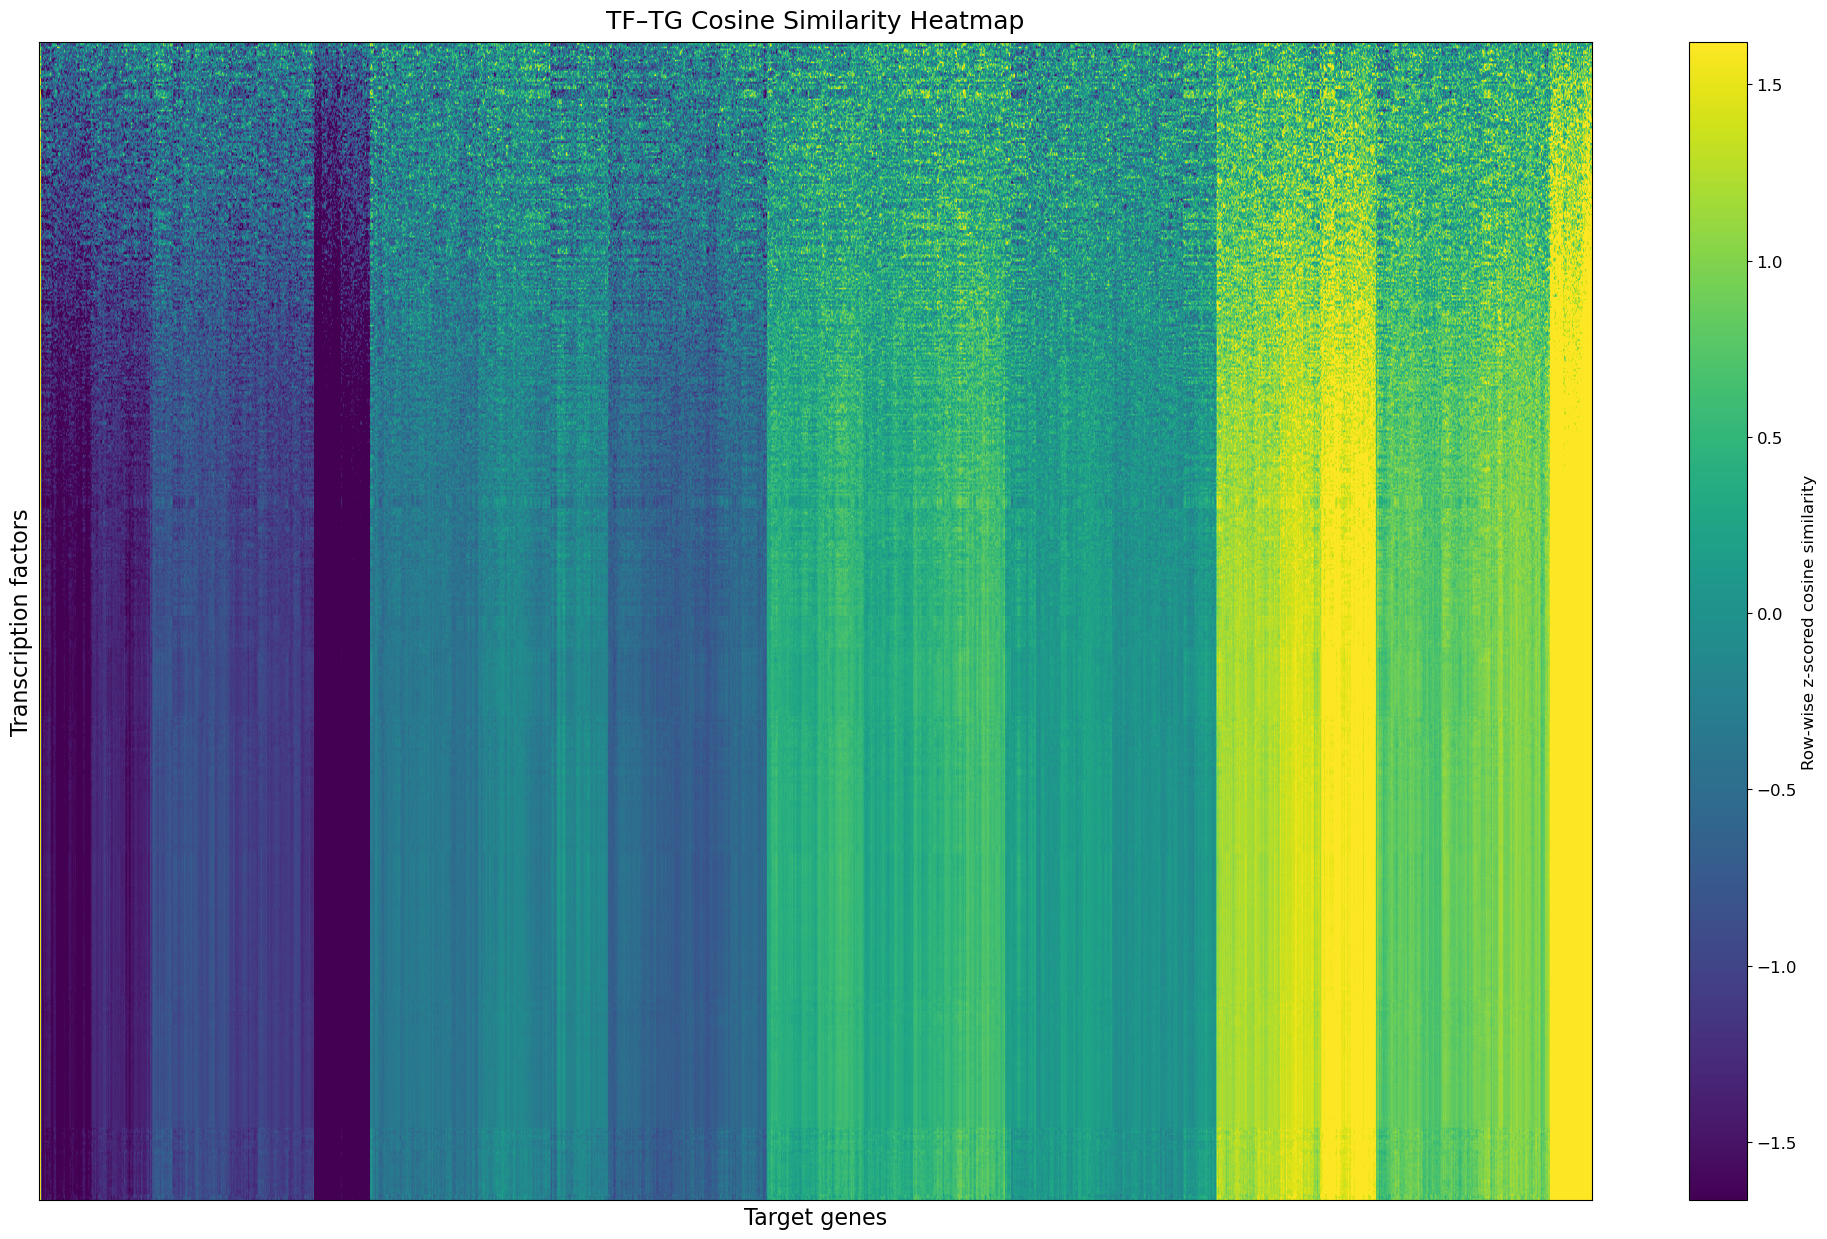

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list


def plot_dense_tf_tg_heatmap(
    emb_path,
    vocab_path,
    tf_indices=None,
    tg_indices=None,
    max_tf=300,
    max_tg=600,
    row_zscore=True,
    cmap="viridis",
):
    """
    Plot a dense TF × TG cosine similarity heatmap for a subset of embeddings.

    - Computes cosine(tf_emb, tg_emb) for chosen TF/TG indices
    - Optionally row-wise z-scores (default: True) so TF-specific high sims stand out
    - Hierarchically clusters rows & columns for block structure
    """

    # ---- Load embeddings & vocab ----
    emb = torch.load(emb_path, map_location="cpu")
    tf_emb = emb["tf_emb"]          # [T, D]
    tg_emb = emb["tg_emb"]          # [G, D] or "tg_query_emb"

    id2name = torch.load(vocab_path, map_location="cpu")
    tf_names_full = id2name.get("tf_id2name", [f"TF_{i}" for i in range(tf_emb.shape[0])])
    tg_names_full = id2name.get("tg_id2name", [f"TG_{i}" for i in range(tg_emb.shape[0])])

    T = tf_emb.shape[0]
    G = tg_emb.shape[0]

    # ---- Choose subset ----
    if tf_indices is None:
        tf_indices = list(range(min(max_tf, T)))
    if tg_indices is None:
        tg_indices = list(range(min(max_tg, G)))

    # ---- Cosine similarity ----
    tf_norm = F.normalize(tf_emb[tf_indices], p=2, dim=1)      # [T_sub, D]
    tg_norm = F.normalize(tg_emb[tg_indices], p=2, dim=1)      # [G_sub, D]
    sim_sub = (tf_norm @ tg_norm.T).detach().cpu().numpy()     # [T_sub, G_sub]

    tf_labels = [tf_names_full[i] for i in tf_indices]
    tg_labels = [tg_names_full[j] for j in tg_indices]

    # ---- Optional row-wise z-score (highlights TF-specific preferences) ----
    if row_zscore:
        row_mean = sim_sub.mean(axis=1, keepdims=True)
        row_std = sim_sub.std(axis=1, keepdims=True) + 1e-6
        X = (sim_sub - row_mean) / row_std
        cbar_label = "Row-wise z-scored cosine similarity"
    else:
        X = sim_sub
        cbar_label = "Cosine similarity"

    # ---- Hierarchical clustering (rows & columns) ----
    # Use Euclidean over X and X.T to group similar profiles
    row_link = linkage(X,   method="average", metric="euclidean")
    col_link = linkage(X.T, method="average", metric="euclidean")

    row_order = leaves_list(row_link)
    col_order = leaves_list(col_link)

    X_re = X[row_order][:, col_order]
    tf_labels_re = [tf_labels[i] for i in row_order]
    tg_labels_re = [tg_labels[j] for j in col_order]

    n_tf, n_tg = X_re.shape

    # ---- Figure sizing ----
    # Scale size with matrix but clamp to something sane for screens/papers.
    fig_w = max(8, min(20, n_tg * 0.015))
    fig_h = max(6, min(20, n_tf * 0.02))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # ---- Color limits: focus on informative range of X_re ----
    low_p, high_p = np.percentile(X_re, [5, 95])
    im = ax.imshow(X_re, aspect="auto", cmap=cmap, vmin=low_p, vmax=high_p)

    # ---- Tick label logic (adaptive density & fontsize) ----
    max_labels = 40  # max ticks we’ll show per axis to avoid clutter

    # y-axis (TFs)
    if n_tf <= max_labels:
        y_idx = np.arange(n_tf)
    else:
        step = max(1, n_tf // max_labels)
        y_idx = np.arange(0, n_tf, step)
    ax.set_yticks(y_idx)
    ax.get_yaxis().set_ticks([])

    # x-axis (TGs)
    if n_tg <= max_labels:
        x_idx = np.arange(n_tg)
    else:
        step = max(1, n_tg // max_labels)
        x_idx = np.arange(0, n_tg, step)
    ax.set_xticks(x_idx)
    ax.get_xaxis().set_ticks([])

    ax.set_xlabel("Target genes", fontsize=16)
    ax.set_ylabel("Transcription factors", fontsize=16)
    ax.set_title(
        "TF–TG Cosine Similarity Heatmap",
        fontsize=18,
        pad=10,
    )

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, fontsize=12)

    plt.tight_layout()
    return fig

fig = plot_dense_tf_tg_heatmap(
    emb_path=SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings_final.pt",
    vocab_path=SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt",
    max_tf=625,
    max_tg=6852,
)
fig.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_cos_sim_heatmap.png", dpi=200)
plt.show()



### Gene Modules / GO Enrichment

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


def extract_tf_tg_modules_clustered(
    emb_path,
    vocab_path,
    max_tf=None,
    max_tg=None,
    n_tf_clusters=15,
    tf_min_per_module=2,
    tg_min_per_module=15,
    tg_mean_z_thresh=1.0,
    tg_support_frac=0.2,
):
    """
    Extract TF–TG regulatory modules from embedding similarities using:
      - cosine(tf, tg)
      - row-wise z-score (per TF)
      - hierarchical clustering of TFs
      - cluster-specific TG selection

    Args:
      max_tf, max_tg: optionally limit #TF/#TG used.
      n_tf_clusters: number of TF clusters (modules candidates).
      tf_min_per_module: min TFs per module.
      tg_min_per_module: min TGs per module.
      tg_mean_z_thresh: min mean z-score across TFs in a cluster
                        for a TG to be included.
      tg_support_frac: min fraction of TFs in cluster with z>=1.0
                       for that TG (robustness).
    Returns:
      list of dicts: { "tfs": [...], "tgs": [...],
                       "size_tfs": int, "size_tgs": int }
    """

    # ---- Load ----
    emb = torch.load(emb_path, map_location="cpu")
    tf_emb = emb["tf_emb"]          # [T, D]
    tg_emb = emb["tg_emb"]          # [G, D]

    id2name = torch.load(vocab_path, map_location="cpu")
    tf_names_full = id2name.get("tf_id2name", [f"TF_{i}" for i in range(tf_emb.shape[0])])
    tg_names_full = id2name.get("tg_id2name", [f"TG_{i}" for i in range(tg_emb.shape[0])])

    T_tot, _ = tf_emb.shape
    G_tot, _ = tg_emb.shape

    if max_tf is None:
        max_tf = T_tot
    if max_tg is None:
        max_tg = G_tot

    T = min(T_tot, int(max_tf))
    G = min(G_tot, int(max_tg))

    tf_emb = tf_emb[:T]
    tg_emb = tg_emb[:G]
    tf_names = tf_names_full[:T]
    tg_names = tg_names_full[:G]

    # ---- Cosine similarity TF x TG ----
    tf_norm = F.normalize(tf_emb, p=2, dim=1)
    tg_norm = F.normalize(tg_emb, p=2, dim=1)
    sim = (tf_norm @ tg_norm.T).cpu().numpy()   # [T, G]

    # ---- Row-wise z-score (per TF) ----
    mu = sim.mean(axis=1, keepdims=True)
    sigma = sim.std(axis=1, keepdims=True) + 1e-6
    z = (sim - mu) / sigma                      # [T, G]

    # ---- Cluster TFs by similarity of their z-profiles ----
    # distance = 1 - corr, clipped to [0,2] for numerical sanity
    corr = np.corrcoef(z)
    dist = 1.0 - corr
    dist = np.clip(dist, 0.0, 2.0)

    # convert full distance matrix to condensed form
    Y = squareform(dist, checks=False)
    Z_link = linkage(Y, method="average")
    tf_cluster_labels = fcluster(Z_link, t=n_tf_clusters, criterion="maxclust")

    modules = []
    for c in np.unique(tf_cluster_labels):
        tf_idx = np.where(tf_cluster_labels == c)[0]
        if len(tf_idx) < tf_min_per_module:
            continue

        # z-scores for TFs in this cluster: [n_tf_c, G]
        z_sub = z[tf_idx, :]

        # mean z across TFs for each TG
        mean_z = z_sub.mean(axis=0)

        # fraction of TFs with z >= 1.0 for each TG
        support = (z_sub >= 1.0).mean(axis=0)

        # TGs that are consistently high for this cluster
        tg_idx = np.where(
            (mean_z >= tg_mean_z_thresh) & (support >= tg_support_frac)
        )[0]

        if len(tg_idx) < tg_min_per_module:
            continue

        mod_tfs = [tf_names[i] for i in tf_idx]
        mod_tgs = [tg_names[j] for j in tg_idx]

        modules.append(
            {
                "tfs": mod_tfs,
                "tgs": mod_tgs,
                "size_tfs": len(mod_tfs),
                "size_tgs": len(mod_tgs),
            }
        )

    # sort modules by "mass"
    modules.sort(key=lambda m: m["size_tfs"] * m["size_tgs"], reverse=True)
    return modules

modules = extract_tf_tg_modules_clustered(
    emb_path=SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings_final.pt",
    vocab_path=SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt",
    max_tf=625,
    max_tg=6852,
    n_tf_clusters=20,      # try 10–30
    tf_min_per_module=3,
    tg_min_per_module=10,
    tg_mean_z_thresh=1.5,  # raise to 1.5 for stricter modules
    tg_support_frac=0.3,  # TG must be high for >=25% of TFs in cluster
)

print(f"Found {len(modules)} modules.")
for k, m in enumerate(modules[:5], 1):
    print(f"\nModule {k}: {m['size_tfs']} TFs, {m['size_tgs']} TGs")
    print("  TFs:", ", ".join(m["tfs"][:10]))
    print("  TGs (first 15):", ", ".join(m["tgs"][:10]), "...")


Found 1 modules.

Module 1: 603 TFs, 298 TGs
  TFs: 2810021J22RIK, 4930522L14RIK, AEBP2, AHR, AHRR, ALX1, ALX4, AR, ARID3A, ARID3C
  TGs (first 15): 1110059G10RIK, 1700001K19RIK, 1700086O06RIK, 1700094J05RIK, 1700096K18RIK, 1810034E14RIK, 3830408C21RIK, 4930527F14RIK, 4933439K11RIK, A930012L18RIK ...


In [ ]:
def run_go_enrichment_for_modules_tf_and_tg(
    modules,
    background_genes,
    organism="Mouse",   # or "Human"
    go_library="GO_Biological_Process_2021",
    fdr_cutoff=0.05,
):
    """
    Run GO enrichment (via Enrichr) for TF∪TG genes in each module.

    Returns
    -------
    enr_by_module : dict[int -> pd.DataFrame]
        Enrichment results per module (one DataFrame per module).
    summary_df : pd.DataFrame
        One row per module with top GO term(s) and basic stats.
    """
    enr_by_module = {}
    summary_rows = []

    bg_genes = list(set(background_genes))

    for midx, m in enumerate(modules, start=1):
        # ---- include BOTH TFs and TGs in this module ----
        genes = list(set(m["tfs"]) | set(m["tgs"]))
        genes = [g for g in genes if g in bg_genes]

        if len(genes) < 5:
            # too few genes for meaningful GO
            continue

        print(f"Running GO for module {midx}: {len(genes)} genes (TF+TG)")

        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=[go_library],
            organism=organism,
            background=bg_genes,
            cutoff=fdr_cutoff,
            outdir=None,
        )

        res = enr.results.copy()
        if res.empty:
            continue

        # store full results
        enr_by_module[midx] = res

        # how many distinct genes from this module appear in any term?
        if "Genes" in res.columns:
            hits = set()
            for gstr in res["Genes"]:
                if isinstance(gstr, str):
                    hits.update(gstr.split(";"))
            n_hits = len(hits)
        else:
            n_hits = np.nan

        # terms passing FDR cutoff
        res_sig = res[res["Adjusted P-value"] <= fdr_cutoff]
        n_sig = res_sig.shape[0]

        if n_sig > 0:
            top = res_sig.sort_values("Adjusted P-value").iloc[0]
            top_term = top["Term"]
            top_padj = top["Adjusted P-value"]
        else:
            top_term = None
            top_padj = np.nan

        summary_rows.append({
            "module_id": midx,
            "n_tfs": m["size_tfs"],
            "n_tgs": m["size_tgs"],
            "n_genes_used": len(genes),
            "n_go_terms_sig": n_sig,
            "n_genes_in_GO_hits": n_hits,
            "top_term": top_term,
            "top_term_padj": top_padj,
        })

    summary_df = pd.DataFrame(summary_rows).sort_values(
        ["n_go_terms_sig", "top_term_padj"], ascending=[False, True]
    )
    return enr_by_module, summary_df


def run_multi_library_enrichment_for_modules(
    modules,
    background_genes,
    organism="Mouse",
    libraries=None,
    fdr_cutoff=0.05,
):
    """
    Run TF+TG enrichment for several gene set libraries.

    libraries: dict like
        {
            "GO_BP": "GO_Biological_Process_2021",
            "KEGG": "KEGG_2019_Mouse",
            "Reactome": "Reactome_2016",
        }
    Returns
    -------
    enr_all : dict[str -> dict[int -> DataFrame]]
        enr_all[library_label][module_id] = enrichment DataFrame.
    summary_all : pd.DataFrame
        Combined summary across libraries with a 'library' column.
    """
    if libraries is None:
        libraries = {
            "GO_BP": "GO_Biological_Process_2021",
        }

    enr_all = {}
    summary_list = []

    for label, gene_set_name in libraries.items():
        print(f"\n=== Running enrichment for {label} ({gene_set_name}) ===")
        try:
            enr_by_module, summary_df = run_go_enrichment_for_modules_tf_and_tg(
                modules,
                background_genes=background_genes,
                organism=organism,
                go_library=gene_set_name,
                fdr_cutoff=fdr_cutoff,
            )
        except Exception as e:
            # You can narrow this to EnrichrValidationError if you like
            print(f"  !! Skipping {label} ({gene_set_name}) due to error: {e}")
            continue

        enr_all[label] = enr_by_module

        summary_df = summary_df.copy()
        summary_df["library"] = label
        summary_list.append(summary_df)

    if summary_list:
        summary_all = pd.concat(summary_list, ignore_index=True)
    else:
        summary_all = pd.DataFrame()

    return enr_all, summary_all

def get_valid_libraries(candidates):
    """
    candidates: dict label -> library_name (Enrichr name)
    Returns a filtered dict with only those that exist on this Enrichr server.
    """
    available = set(gp.get_library_name())  # list of valid names
    print("Available libraries on Enrichr server:", available)

    valid = {}
    for label, lib in candidates.items():
        if lib in available:
            valid[label] = lib
        else:
            print(f"[WARN] Library not found on this Enrichr server: {lib} (label={label})")
    return valid


In [ ]:
candidate_libraries = {
    "GO_BP": "GO_Biological_Process_2021",
    "KEGG":  "KEGG_2019_Mouse",     # or similar
    "Reactome": "Reactome_2022",
}

libraries = get_valid_libraries(candidate_libraries)
print("Using libraries:", libraries)

id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
background_genes = [g for g in id2name["tg_id2name"]]  # list of all TG gene symbols

enr_all, summary_all = run_multi_library_enrichment_for_modules(
    modules,
    background_genes=background_genes,
    organism="Mouse",
    libraries=libraries,
    fdr_cutoff=0.05,
)


Available libraries on Enrichr server: {'UK_Biobank_GWAS_v1', 'PFOCR_Pathways_2023', 'LINCS_L1000_Chem_Pert_down', 'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X', 'Old_CMAP_up', 'Allen_Brain_Atlas_down', 'TG_GATES_2020', 'Jensen_DISEASES_Curated_2025', 'Virus-Host_PPI_P-HIPSTer_2020', 'TRRUST_Transcription_Factors_2019', 'Jensen_DISEASES_Experimental_2025', 'Mouse_Gene_Atlas', 'huMAP', 'lncHUB_lncRNA_Co-Expression', 'KEGG_2019_Human', 'Azimuth_2023', 'LINCS_L1000_Chem_Pert_up', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'JASPAR_PWM_Mouse_2025', 'Microbe_Perturbations_from_GEO_up', 'GO_Cellular_Component_2021', 'CellMarker_Augmented_2021', 'ENCODE_TF_ChIP-seq_2014', 'HuBMAP_ASCTplusB_augmented_2022', 'L1000_Kinase_and_GPCR_Perturbations_up', 'InterPro_Domains_2019', 'ENCODE_Histone_Modifications_2015', 'NIBR_DRUGseq_2025_up', 'WikiPathway_2023_Human', 'Enrichr_Submissions_TF-Gene_Coocurrence', 'HDSigDB_Human_2021', 'ProteomicsDB_2020', 'GWAS_Catalog_2025', 'ClinVar_2019', 'GTEx_Aging

In [ ]:
GENERIC_PATTERNS = [
    "regulation of transcription, dna-templated",
    "regulation of transcription by rna polymerase ii",
    "herpes simplex virus 1 infection",
    "bacterial invasion of epithelial cells",
    "maturity onset diabetes of the young",
]

def is_generic_term(term: str) -> bool:
    t = term.lower()
    return any(pat in t for pat in GENERIC_PATTERNS)

def print_all_non_generic_pathways(
    enr_all,
    padj_thresh=0.05,
    max_terms_per_lib=None,   # e.g. 5; or None for all
    lib_label_map=None,
):
    """
    enr_all: dict[label -> dict[module_id -> DataFrame]]
             from run_multi_library_enrichment_for_modules
    Prints ALL significant (padj <= padj_thresh) pathways per module,
    excluding generic terms defined by is_generic_term().
    """
    if lib_label_map is None:
        lib_label_map = {"GO_BP": "GO", "KEGG": "KEGG", "Reactome": "Reactome"}

    # collect all module_ids across libraries
    all_module_ids = set()
    for lib_label, mod_dict in enr_all.items():
        all_module_ids.update(mod_dict.keys())

    for mid in sorted(all_module_ids):
        module_lines = []

        for lib_label, mod_dict in enr_all.items():
            if mid not in mod_dict:
                continue

            df_lib = mod_dict[mid]
            if "Adjusted P-value" not in df_lib.columns or "Term" not in df_lib.columns:
                continue

            df_sig = df_lib[df_lib["Adjusted P-value"] <= padj_thresh].copy()
            if df_sig.empty:
                continue

            # drop generic terms
            df_sig = df_sig[~df_sig["Term"].map(is_generic_term)]
            if df_sig.empty:
                continue

            # sort by padj and optionally limit
            df_sig = df_sig.sort_values("Adjusted P-value")
            if max_terms_per_lib is not None:
                df_sig = df_sig.head(max_terms_per_lib)

            pretty_lib = lib_label_map.get(lib_label, lib_label)

            # collect lines for this lib
            for row in df_sig.itertuples():
                term = row.Term
                padj = float(row._asdict().get("Adjusted P-value", row._asdict().get("Adjusted_P_value", np.nan)))
                module_lines.append(f"  - {pretty_lib}: {term} (padj={padj:.2e})")

        # only print modules that have at least one non-generic significant term
        if module_lines:
            print(f"Module {mid}:")
            for ln in module_lines:
                print(ln)
            print()
print_all_non_generic_pathways(
    enr_all,
    padj_thresh=0.05,
    max_terms_per_lib=5,   # or None to dump everything
)


Module 1:
  - GO: positive regulation of nucleic acid-templated transcription (GO:1903508) (padj=nan)
  - GO: negative regulation of nucleic acid-templated transcription (GO:1903507) (padj=nan)
  - GO: negative regulation of cellular macromolecule biosynthetic process (GO:2000113) (padj=nan)
  - GO: regulation of nucleic acid-templated transcription (GO:1903506) (padj=nan)
  - GO: regulation of cellular macromolecule biosynthetic process (GO:2000112) (padj=nan)
  - KEGG: Transcriptional misregulation in cancer (padj=nan)
  - KEGG: Human T-cell leukemia virus 1 infection (padj=nan)
  - KEGG: Hepatitis B (padj=nan)
  - KEGG: Th17 cell differentiation (padj=nan)
  - KEGG: Signaling pathways regulating pluripotency of stem cells (padj=nan)
  - Reactome: Generic Transcription Pathway R-HSA-212436 (padj=nan)
  - Reactome: Gene Expression (Transcription) R-HSA-74160 (padj=nan)
  - Reactome: RNA Polymerase II Transcription R-HSA-73857 (padj=nan)
  - Reactome: Nuclear Receptor Transcription Pat

Overlap between modules

In [ ]:
for i in range(len(modules)):
    for j in range(i+1, len(modules)):
        overlap = len(set(modules[i]["tgs"]) & set(modules[j]["tgs"]))
        if overlap > 0:
            print(f"Module {i+1} & {j+1}: TG overlap = {overlap}")


### Evalute TF-TG embedding cosine similarity on ChIP-seq Ground Truth

Total ChIP edges in file: 977841
ChIP edges with TF+TG in embedding vocab: 54239
Unique TFs in GT & vocab: 34
Unique TGs in GT & vocab: 6041



[All TFs, cosine] Overall GT fraction: 0.012387779358253692
Balanced: 108478 pairs (pos=54239, neg=54239, ratio=1.00)

[All TFs, cosine, BALANCED] GT enrichment in high-score pairs vs rest:
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
    0.900  -0.153352  10848     0.679941     97630        0.480006         1.416526
    0.950  -0.120854   5424     0.714786    103054        0.488695         1.462642
    0.990  -0.055747   1085     0.718894    107393        0.497788         1.444176
    0.995  -0.033192    543     0.727440    107935        0.498856         1.458217

[All TFs, cosine, BALANCED] Mann–Whitney (GT > non-GT): p=6.880e-223, GT mean=-0.2101, non-GT mean=-0.2217

[ChIP TFs only, cosine] Overall GT fraction: 0.23281738264482676
Balanced: 108478 pairs (pos=54239, neg=54239, ratio=1.00)

[ChIP TFs only, cosine, BALANCED] GT enrichment in high-score pairs vs rest:
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_

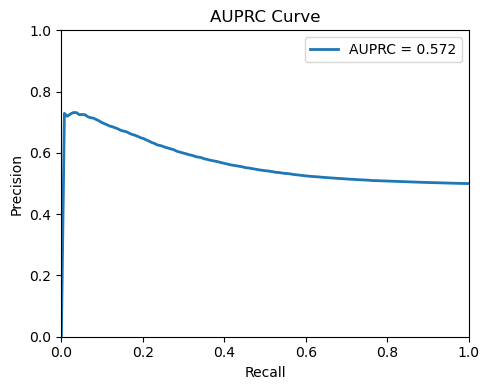

Balanced AUROC: 0.5558


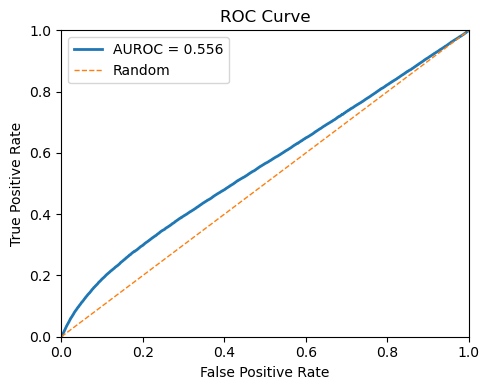

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

# =========================
# 1. Load embeddings + vocab
# =========================

def balance_pos_neg(df, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0):
    """
    Return a dataframe with a controlled positive:negative ratio.

    pos_to_neg_ratio = 1.0  -> equal # positives and negatives
    """
    rng = np.random.default_rng(random_state)

    pos_df = df[df[label_col] == True]
    neg_df = df[df[label_col] == False]

    n_pos = len(pos_df)
    n_neg_desired = int(n_pos * pos_to_neg_ratio)

    if n_pos == 0:
        print("Warning: no positives found, cannot balance.")
        return df.copy()

    n_neg_desired = min(n_neg_desired, len(neg_df))

    neg_idx = rng.choice(neg_df.index.to_numpy(), size=n_neg_desired, replace=False)
    neg_sample = neg_df.loc[neg_idx]

    balanced = pd.concat([pos_df, neg_sample], axis=0)
    balanced = balanced.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    print(
        f"Balanced: {len(balanced)} pairs "
        f"(pos={len(pos_df)}, neg={len(neg_sample)}, "
        f"ratio={len(pos_df)/(len(neg_sample)+1e-12):.2f})"
    )
    return balanced

emb = torch.load(SELECTED_EXPERIMENT_DIR / tf_emb_file, map_location="cpu")
id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")

tf_emb = emb["tf_emb"]            # [T, D]
tg_emb = emb["tg_emb"]            # [G, D]

tf_names = list(id2name["tf_id2name"])
tg_names = list(id2name["tg_id2name"])

T, _ = tf_emb.shape
G, _ = tg_emb.shape

tf_index = {g: i for i, g in enumerate(tf_names)}
tg_index = {g: i for i, g in enumerate(tg_names)}

# cosine similarity matrix [T, G]
tf_norm = F.normalize(tf_emb, p=2, dim=1)
tg_norm = F.normalize(tg_emb, p=2, dim=1)
sim = (tf_norm @ tg_norm.T).cpu().numpy()

# per-TF row-wise z-scores of cosine
mu = sim.mean(axis=1, keepdims=True)
sigma = sim.std(axis=1, keepdims=True) + 1e-6
z = (sim - mu) / sigma   # [T, G]

# =========================
# 2. Load ChIP-seq ground truth
# =========================


chip = ground_truth_df.copy()

print("Total ChIP edges in file:", len(chip))

# keep only edges that exist in our TF/TG vocab
chip["tf_in"] = chip["tf"].isin(tf_index)
chip["tg_in"] = chip["tg"].isin(tg_index)
chip_valid = chip[chip["tf_in"] & chip["tg_in"]].copy()

print("ChIP edges with TF+TG in embedding vocab:", len(chip_valid))
print("Unique TFs in GT & vocab:", chip_valid["tf"].nunique())
print("Unique TGs in GT & vocab:", chip_valid["tg"].nunique())

# set of GT edges (for lookup)
gt_set = set(zip(chip_valid["tf"], chip_valid["tg"]))

# =========================
# 3. Helper: build full pair DF
# =========================

def build_all_pairs_df(scores_matrix, score_name="score", restrict_tf_idx=None):
    """
    scores_matrix: [T, G] array
    restrict_tf_idx: optional list of TF indices to keep (rows)
    """
    if restrict_tf_idx is None:
        tf_idx = np.arange(T)
    else:
        tf_idx = np.array(restrict_tf_idx, dtype=int)

    # indices
    tf_grid, tg_grid = np.meshgrid(tf_idx, np.arange(G), indexing="ij")
    tf_flat = tf_grid.ravel()
    tg_flat = tg_grid.ravel()

    vals = scores_matrix[tf_flat, tg_flat]
    tfs = np.array(tf_names, dtype=object)[tf_flat]
    tgs = np.array(tg_names, dtype=object)[tg_flat]

    df = pd.DataFrame({
        "tf": tfs,
        "tg": tgs,
        score_name: vals,
    })
    df["is_gt"] = list(map(gt_set.__contains__, zip(df["tf"], df["tg"])))
    return df

def enrichment_by_quantile(df, score_col, quantiles=(0.9, 0.95, 0.99, 0.995)):
    rows = []
    for q in quantiles:
        thr = df[score_col].quantile(q)
        top = df[df[score_col] >= thr]
        bottom = df[df[score_col] < thr]
        top_gt = top["is_gt"].mean()
        bot_gt = bottom["is_gt"].mean()
        rows.append({
            "quantile": q,
            "threshold": float(thr),
            "top_n": int(len(top)),
            "top_gt_frac": float(top_gt),
            "bottom_n": int(len(bottom)),
            "bottom_gt_frac": float(bot_gt),
            "enrichment_fold": float(top_gt / (bot_gt + 1e-12)),
        })
    return pd.DataFrame(rows)

def mannwhitney_gt_vs_non(df, score_col):
    gt_scores = df.loc[df["is_gt"], score_col].values
    non_scores = df.loc[~df["is_gt"], score_col].values
    if len(gt_scores) == 0:
        return None

    if len(non_scores) > 500_000:
        rng = np.random.default_rng(0)
        non_scores = rng.choice(non_scores, size=500_000, replace=False)

    u, p = mannwhitneyu(gt_scores, non_scores, alternative="greater")
    return {
        "p": float(p),
        "gt_mean": float(gt_scores.mean()),
        "non_gt_mean": float(non_scores.mean()),
        "n_gt": int(len(gt_scores)),
        "n_non_gt": int(len(non_scores)),
    }

# =========================
# 4. (a) ORIGINAL: all TFs, cosine
# =========================

all_cos = build_all_pairs_df(sim, score_name="score_all")
print("\n[All TFs, cosine] Overall GT fraction:", all_cos["is_gt"].mean())

# balance positives and negatives (1:1)
all_cos_bal = balance_pos_neg(all_cos, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0)

cos_enr_all = enrichment_by_quantile(all_cos_bal, "score_all")
print("\n[All TFs, cosine, BALANCED] GT enrichment in high-score pairs vs rest:")
print(cos_enr_all.to_string(index=False))

mw_all_cos = mannwhitney_gt_vs_non(all_cos_bal, "score_all")
if mw_all_cos:
    print(f"\n[All TFs, cosine, BALANCED] Mann–Whitney (GT > non-GT): "
          f"p={mw_all_cos['p']:.3e}, "
          f"GT mean={mw_all_cos['gt_mean']:.4f}, "
          f"non-GT mean={mw_all_cos['non_gt_mean']:.4f}")

# =========================
# 5. (a) Restricted: only TFs that appear in ChIP
# =========================

chip_tf_set = set(chip_valid["tf"].unique())
chip_tf_idx = [tf_index[t] for t in chip_tf_set if t in tf_index]

# 5. ChIP TFs only, cosine
cos_chip_tf = build_all_pairs_df(sim, score_name="score_chip_tf", restrict_tf_idx=chip_tf_idx)
print("\n[ChIP TFs only, cosine] Overall GT fraction:", cos_chip_tf["is_gt"].mean())

cos_chip_tf_bal = balance_pos_neg(cos_chip_tf, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0)

cos_enr_chip_tf = enrichment_by_quantile(cos_chip_tf_bal, "score_chip_tf")
print("\n[ChIP TFs only, cosine, BALANCED] GT enrichment in high-score pairs vs rest:")
print(cos_enr_chip_tf.to_string(index=False))

mw_chip_tf_cos = mannwhitney_gt_vs_non(cos_chip_tf_bal, "score_chip_tf")
if mw_chip_tf_cos:
    print(f"\n[ChIP TFs only, cosine, BALANCED] Mann–Whitney (GT > non-GT): "
          f"p={mw_chip_tf_cos['p']:.3e}, "
          f"GT mean={mw_chip_tf_cos['gt_mean']:.4f}, "
          f"non-GT mean={mw_chip_tf_cos['non_gt_mean']:.4f}")

# =========================
# 6. (b) Use per-TF z-scores instead of raw cosine
# =========================

# All TFs, z-score
all_z = build_all_pairs_df(z, score_name="z_all")
print("\n[All TFs, z] Overall GT fraction:", all_z["is_gt"].mean())

all_z_bal = balance_pos_neg(all_z, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0)


z_enr_all = enrichment_by_quantile(all_z_bal, "z_all")
print("\n[All TFs, z] GT enrichment in high-z pairs vs rest:")
print(z_enr_all.to_string(index=False))

mw_all_z = mannwhitney_gt_vs_non(all_z_bal, "z_all")
if mw_all_z:
    print(f"\n[All TFs, z] Mann–Whitney (GT > non-GT): "
          f"p={mw_all_z['p']:.3e}, "
          f"GT mean={mw_all_z['gt_mean']:.4f}, "
          f"non-GT mean={mw_all_z['non_gt_mean']:.4f}")

# ChIP TFs only, z-score
z_chip_tf = build_all_pairs_df(z, score_name="z_chip_tf", restrict_tf_idx=chip_tf_idx)
print("\n[ChIP TFs only, z] Overall GT fraction:", z_chip_tf["is_gt"].mean())

z_chip_tf_bal = balance_pos_neg(z_chip_tf, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0)


z_enr_chip_tf = enrichment_by_quantile(z_chip_tf_bal, "z_chip_tf")
print("\n[ChIP TFs only, z] GT enrichment in high-z pairs vs rest:")
print(z_enr_chip_tf.to_string(index=False))

mw_chip_tf_z = mannwhitney_gt_vs_non(z_chip_tf_bal, "z_chip_tf")
if mw_chip_tf_z:
    print(f"\n[ChIP TFs only, z] Mann–Whitney (GT > non-GT): "
          f"p={mw_chip_tf_z['p']:.3e}, "
          f"GT mean={mw_chip_tf_z['gt_mean']:.4f}, "
          f"non-GT mean={mw_chip_tf_z['non_gt_mean']:.4f}")

# =========================
# 7. (c) Precision–Recall using cosine similarity (ChIP TFs only)
# =========================

options = {
    "all_tf_cos": all_cos_bal,
    "matching_tf_cos": cos_chip_tf_bal,
    "all_tf_z": all_z_bal,
    "matching_tf_z": z_chip_tf_bal,
    }
selected_option = options["all_tf_cos"]

def pr_curve(scores, labels):
    """Compute precision-recall for sorted scores (descending)."""
    order = np.argsort(-scores)
    labels_sorted = labels[order].astype(int)
    tp_cum = np.cumsum(labels_sorted)
    idx = np.arange(1, len(labels_sorted) + 1)

    total_pos = tp_cum[-1]
    if total_pos == 0:
        return np.array([0.0]), np.array([0.0])

    precision = tp_cum / idx
    recall = tp_cum / total_pos
    return precision, recall

# Use cosine similarity for ChIP TFs only, **balanced 1:1**
scores_cos = selected_option["score_all"].values
labels = selected_option["is_gt"].values.astype(int)

prec, rec = pr_curve(scores_cos, labels)

# (Optional) subsample for plotting clarity
def subsample_pr(rec, prec, num=200):
    if len(rec) <= num:
        return rec, prec
    idx = np.linspace(0, len(rec) - 1, num=num).astype(int)
    return rec[idx], prec[idx]

rec_s, prec_s = subsample_pr(rec, prec, num=200)

# Compute AUROC on the balanced set
from sklearn.metrics import average_precision_score

auprc_bal = average_precision_score(labels, scores_cos)
print(f"Balanced AUPRC: {auprc_bal:.4f}")

auprc_plot = plt.figure(figsize=(5,4))
plt.plot(rec_s, prec_s, marker="", linewidth=2, label=f"AUPRC = {auprc_bal:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AUPRC Curve")
plt.legend()
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_auc_score, roc_curve

# =========================
# 7. (d) Balanced ROC / AUROC using cosine similarity (ChIP TFs only)
# =========================

# scores_cos and labels already come from cos_chip_tf_bal (balanced 1:1)
# scores_cos = cos_chip_tf_bal["score_chip_tf"].values
# labels = cos_chip_tf_bal["is_gt"].values.astype(int)

# Compute AUROC on the balanced set
auroc_bal = roc_auc_score(labels, scores_cos)
print(f"Balanced AUROC: {auroc_bal:.4f}")

# ROC curve
fpr, tpr, thresh = roc_curve(labels, scores_cos)

auroc_plot = plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, linewidth=2, label=f"AUROC = {auroc_bal:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

auprc_plot.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_cosine_auprc_curve.png", dpi=200)
auroc_plot.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_cosine_auroc_curve.png", dpi=200)


Total ChIP edges in file: 2123263
ChIP edges with TF+TG in embedding vocab: 259402
Unique TFs in GT & vocab: 187
Universe (ChIP TFs only): 187 TFs × 6852 TGs = 1281324 pairs

[ChIP TFs only, cosine] Overall GT fraction: 0.202448
Best AUROC: 0.5064 (at quantile ≥ 0.960)


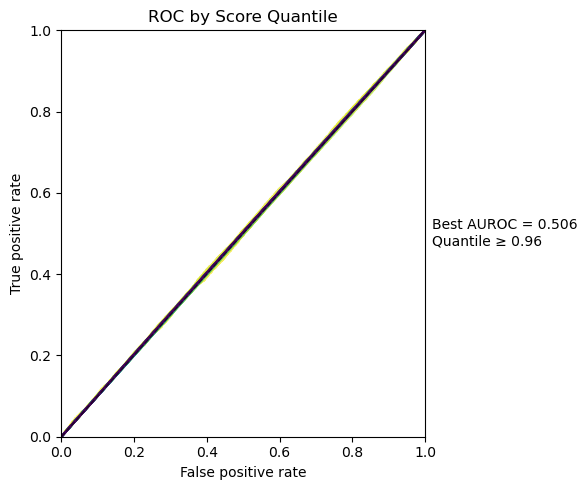

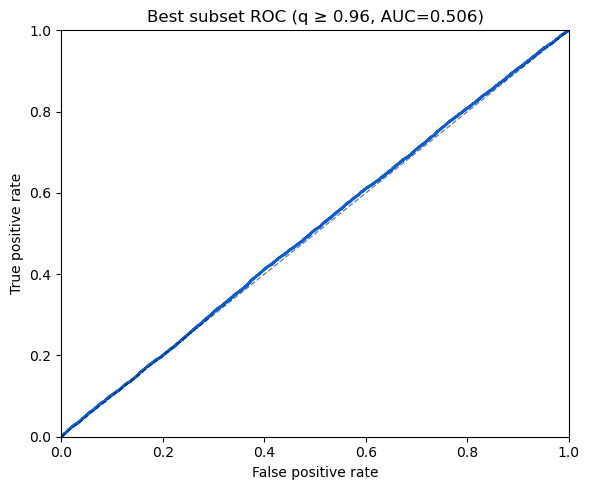

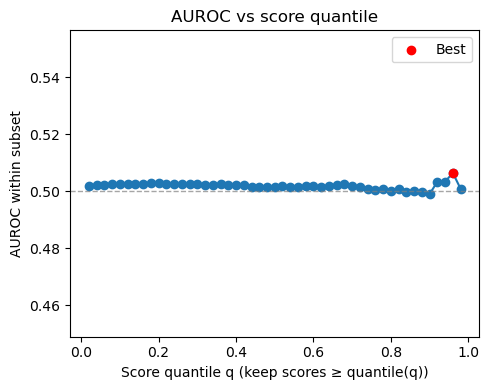

In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

# ----------------- small helpers -----------------

def _canonicalize_name(s):
    # leave missing values as-is
    if s is None or (isinstance(s, float) and math.isnan(s)):
        return s
    # normal string case
    if isinstance(s, str):
        return s.strip()
    # anything else → convert to string and strip
    return str(s).strip()

def _compute_roc_auc(y_true, scores):
    """
    Minimal ROC/AUC for binary labels y_true in {0,1} and real-valued scores.
    Returns fpr, tpr, auc.
    """
    y_true = np.asarray(y_true, dtype=np.int8)
    scores = np.asarray(scores, dtype=np.float64)

    # sort by descending score
    order = np.argsort(-scores)
    y = y_true[order]

    P = y.sum()
    N = len(y) - P
    if P == 0 or N == 0:
        return np.array([0, 1]), np.array([0, 1]), np.nan

    # cumulative TP/FP as we move threshold down
    tp = np.cumsum(y)
    fp = np.cumsum(1 - y)

    tpr = tp / P
    fpr = fp / N

    # prepend (0,0)
    tpr = np.concatenate([[0.0], tpr])
    fpr = np.concatenate([[0.0], fpr])

    # trapezoidal AUC
    auc = np.trapezoid(tpr, fpr)
    return fpr, tpr, auc

# ----------------- main plotting function -----------------

def plot_chiptf_cosine_auroc_by_quantile(
    emb_path,
    vocab_path,
    chip_df,
    quantile_step=0.01,
    cmap_name="viridis",
):
    """
    For the 'ChIP TFs only, cosine' group:
      - build all TF–TG pairs for TFs that appear in ChIP ground truth
      - label them as GT / non-GT
      - for q in [1, 1-quantile_step, ..., >0]:
          * keep only pairs with score >= quantile(q)
          * compute ROC and AUROC within that subset
      - plot all ROC curves with a color gradient
      - plot AUROC vs quantile in a separate figure.

    Returns
    -------
    fig_roc : matplotlib Figure
        ROC-family figure.
    fig_auc : matplotlib Figure
        AUROC-vs-quantile figure.
    """

    # ----- load embeddings + vocab -----
    emb = torch.load(emb_path, map_location="cpu")
    tf_emb = emb["tf_emb"]        # [T, D]
    tg_emb = emb["tg_emb"]        # [G, D]

    id2name = torch.load(vocab_path, map_location="cpu")
    tf_names = [_canonicalize_name(n).upper() for n in id2name["tf_id2name"]]
    tg_names = [_canonicalize_name(n).upper() for n in id2name["tg_id2name"]]

    T, D = tf_emb.shape
    G, _ = tg_emb.shape

    # cosine similarities
    tf_norm = F.normalize(tf_emb, p=2, dim=1)
    tg_norm = F.normalize(tg_emb, p=2, dim=1)
    sim = (tf_norm @ tg_norm.T).cpu().numpy()   # [T, G]

    # map names -> indices
    tf_name2idx = {n: i for i, n in enumerate(tf_names)}
    tg_name2idx = {n: i for i, n in enumerate(tg_names)}

    # keep only edges where TF + TG are in vocab
    chip_edges = []
    for tf, tg in zip(chip_df["tf"], chip_df["tg"]):
        ti = tf_name2idx.get(tf)
        gi = tg_name2idx.get(tg)
        if ti is not None and gi is not None:
            chip_edges.append((ti, gi))

    chip_edges = np.array(chip_edges, dtype=int)
    print(f"Total ChIP edges in file: {len(chip_df)}")
    print(f"ChIP edges with TF+TG in embedding vocab: {len(chip_edges)}")

    if len(chip_edges) == 0:
        raise ValueError("No overlapping ChIP edges with embedding vocab.")

    # ----- restrict to 'ChIP TFs only' universe -----
    chiptf_idx = np.unique(chip_edges[:, 0])          # TF indices with ChIP info
    print(f"Unique TFs in GT & vocab: {len(chiptf_idx)}")

    # all candidate pairs for these TFs x all TGs
    sim_sub = sim[chiptf_idx, :]
    n_tf_sub, n_tg = sim_sub.shape
    print(f"Universe (ChIP TFs only): {n_tf_sub} TFs × {n_tg} TGs = {n_tf_sub * n_tg} pairs")

    # build GT mask in this universe
    gt_mask = np.zeros_like(sim_sub, dtype=bool)
    tf_global_to_row = {tf: i for i, tf in enumerate(chiptf_idx)}
    for ti, gi in chip_edges:
        row = tf_global_to_row.get(ti)
        if row is not None and 0 <= gi < n_tg:
            gt_mask[row, gi] = True

    # flatten
    scores_flat = sim_sub.reshape(-1)
    y_flat = gt_mask.reshape(-1).astype(int)

    overall_frac = y_flat.mean()
    print(f"\n[ChIP TFs only, cosine] Overall GT fraction: {overall_frac:.6f}")

    # ----- ROC curves by quantile subset -----
    quantiles = np.arange(1.0, 0.0, -quantile_step)
    cmap = plt.get_cmap(cmap_name)

    fig_roc, ax_roc = plt.subplots(figsize=(6, 5))

    qs_used = []
    auc_scores = []


    for i, q in enumerate(quantiles):
        thr = np.quantile(scores_flat, q)
        mask = scores_flat >= thr
        y_sub = y_flat[mask]
        s_sub = scores_flat[mask]

        # skip degenerate subsets
        if y_sub.sum() == 0 or y_sub.sum() == len(y_sub):
            continue

        fpr, tpr, auc = _compute_roc_auc(y_sub, s_sub)

        t = float(i) / max(1, len(quantiles) - 1)
        color = cmap(1.0 - t)
        ax_roc.plot(fpr, tpr, color=color, lw=1.5, alpha=0.7)

        qs_used.append(q)
        auc_scores.append(auc)

    qs_used = np.array(qs_used)
    auc_scores = np.array(auc_scores)

    best_idx = np.nanargmax(auc_scores)
    best_auc = float(auc_scores[best_idx])
    best_q   = float(qs_used[best_idx])
    print(f"Best AUROC: {best_auc:.4f} (at quantile ≥ {best_q:.3f})")

    # diagonal baseline
    ax_roc.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)

    ax_roc.set_xlim(0, 1)
    ax_roc.set_ylim(0, 1)
    ax_roc.set_xlabel("False positive rate")
    ax_roc.set_ylabel("True positive rate")
    ax_roc.set_title("ROC by Score Quantile")

    ax_roc.text(
        1.02, 0.5,
        f"Best AUROC = {best_auc:.3f}\nQuantile ≥ {best_q:.2f}",
        transform=ax_roc.transAxes,
        va="center",
        ha="left",
        clip_on=False,
    )

    plt.tight_layout()
    
    # ----- BEST AUROC -----
    best_thr = np.quantile(scores_flat, best_q)
    best_mask = scores_flat >= best_thr
    y_best = y_flat[best_mask]
    s_best = scores_flat[best_mask]

    fpr_best, tpr_best, auc_best = _compute_roc_auc(y_best, s_best)
    
    fig_best, ax_best = plt.subplots(figsize=(6,5))
    ax_best.plot(fpr_best, tpr_best, color="#085DDB", lw=2)
    ax_best.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
    ax_best.set_xlim(0, 1)
    ax_best.set_ylim(0, 1)
    ax_best.set_xlabel("False positive rate")
    ax_best.set_ylabel("True positive rate")
    ax_best.set_title(f"Best subset ROC (q ≥ {best_q:.2f}, AUC={auc_best:.3f})")
    plt.tight_layout()


    # ----- AUROC vs quantile figure (second figure) -----
    fig_auc, ax_auc = plt.subplots(figsize=(5, 4))
    ax_auc.plot(qs_used, auc_scores, marker="o")
    ax_auc.axhline(0.5, linestyle="--", linewidth=1, color="gray", alpha=0.7)

    ax_auc.set_xlabel("Score quantile q (keep scores ≥ quantile(q))")
    ax_auc.set_ylabel("AUROC within subset")
    ax_auc.set_title("AUROC vs score quantile")

    # highlight best point
    ax_auc.scatter([best_q], [best_auc], color="red", zorder=5, label="Best")
    ax_auc.legend()

    # nice y-limits based on finite values
    finite = np.isfinite(auc_scores)
    if finite.any():
        ymin = max(0.0, np.nanmin(auc_scores) - 0.05)
        ymax = min(1.0, np.nanmax(auc_scores) + 0.05)
        ax_auc.set_ylim(ymin, ymax)

    plt.tight_layout()

    return fig_roc, fig_auc, fig_best

fig_roc, fig_auc, fig_best = plot_chiptf_cosine_auroc_by_quantile(
    emb_path=SELECTED_EXPERIMENT_DIR / tf_emb_file,
    vocab_path=SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt",
    chip_df=ground_truth_df,
    quantile_step=0.02,
)
fig_roc.savefig(SELECTED_EXPERIMENT_DIR / "chiptf_cosine_roc_curves_by_quantile.png", dpi=300)
fig_auc.savefig(SELECTED_EXPERIMENT_DIR / "chiptf_cosine_auc_score_by_quantile.png", dpi=300)
fig_best.savefig(SELECTED_EXPERIMENT_DIR / "chiptf_cosine_best_roc_curve.png", dpi=300)

fig_roc.show()
fig_auc.show()
fig_best.show()

## TF to TG Shortcut Edge Scores

[Shortcut] Overall GT fraction: 0.012387779358253692
Balanced: 108478 pairs (pos=54239, neg=54239, ratio=1.00)
Shortcut AUROC: 0.5863
Shortcut AUPRC: 0.6010


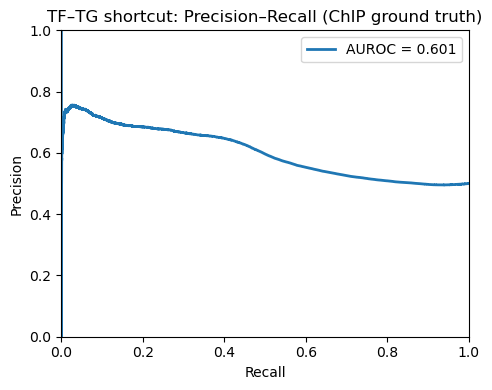

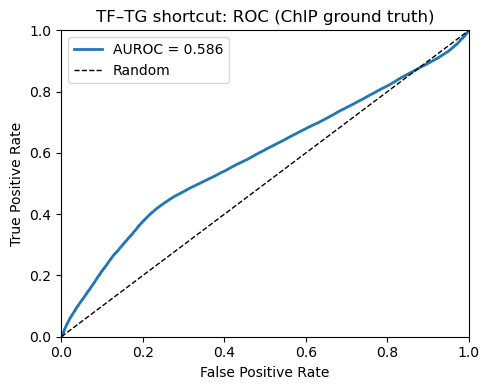

In [ ]:
import torch
import numpy as np

def get_shortcut_edge_scores(model, device, motif_mask=None):
    """
    Run TFtoTGShortcut once on all TF/TG ids and return an edge score matrix.

    Returns
    -------
    scores : np.ndarray of shape [T, G]
        scores[t, g] is the shortcut attention weight from TF t to TG g.
        (Transposed from the internal [G, T] for convenience.)
    """
    model.eval()
    with torch.no_grad():
        # All TF/TG ids
        T = model.tf_identity_emb.num_embeddings
        G = model.tg_identity_emb.num_embeddings

        tf_ids = torch.arange(T, device=device, dtype=torch.long)
        tg_ids = torch.arange(G, device=device, dtype=torch.long)

        # Identity embeddings
        tf_id_emb = model.tf_identity_emb(tf_ids)   # [T, d]
        tg_emb    = model.tg_identity_emb(tg_ids)   # [G, d]

        # Dummy expression (only used to mix TFs; attn itself does not depend on values)
        dummy_tf_expr = torch.ones(1, T, device=device)

        # Optional global motif_mask for all (TG, TF) pairs, shape [G, T], if you have it
        if motif_mask is not None:
            motif_mask = motif_mask.to(device)

        # Call shortcut directly
        # output: [B, G], attn: [G, T]
        _, attn = model.shortcut_layer(
            tg_emb, tf_id_emb, dummy_tf_expr, motif_mask=motif_mask
        )

        # attn[g, t] → transpose to [T, G] to match your build_all_pairs_df
        scores = attn.T.cpu().numpy()

    return scores

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

shortcut_scores = get_shortcut_edge_scores(model, device)  # shape [T, G]

# This assumes build_all_pairs_df expects scores_matrix[tf, tg]
df_shortcut = build_all_pairs_df(shortcut_scores, score_name="shortcut_score")

print("[Shortcut] Overall GT fraction:", df_shortcut["is_gt"].mean())

df_shortcut_bal = balance_pos_neg(
    df_shortcut, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0
)

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import numpy as np

labels = df_shortcut_bal["is_gt"].astype(int).values
scores = df_shortcut_bal["shortcut_score"].values

# AUROC / AUPRC
auroc = roc_auc_score(labels, scores)
auprc = average_precision_score(labels, scores)
print(f"Shortcut AUROC: {auroc:.4f}")
print(f"Shortcut AUPRC: {auprc:.4f}")

# Precision–Recall curve
prec, rec, _ = precision_recall_curve(labels, scores)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, lw=2, label=f"AUROC = {auprc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("TF–TG shortcut: Precision–Recall (ChIP ground truth)")
plt.legend()
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_shortcut_pr_curve.png", dpi=200)
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(labels, scores)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUROC = {auroc:.3f}")
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TF–TG shortcut: ROC (ChIP ground truth)")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_shortcut_roc_curve.png", dpi=200)
plt.show()


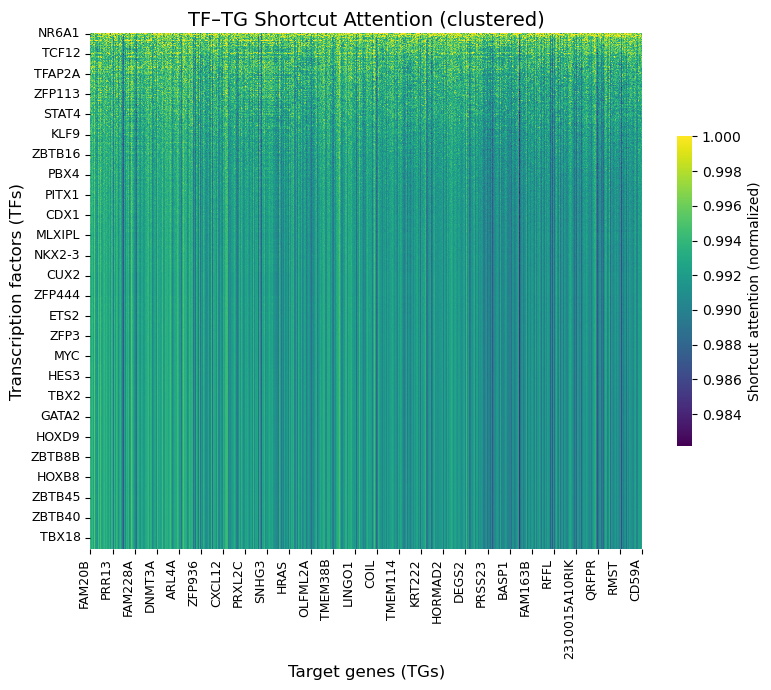

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) Build shortcut attention DataFrame [T, G] ---

# Load TF/TG names (if not already in memory)
id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt",
                     map_location="cpu")
tf_names = list(id2name["tf_id2name"])
tg_names = list(id2name["tg_id2name"])

# shortcut_scores: [T, G] from your get_shortcut_edge_scores()
assert shortcut_scores.shape == (len(tf_names), len(tg_names))

shortcut_df = pd.DataFrame(
    shortcut_scores,
    index=tf_names,
    columns=tg_names,
)

# --- 2) Optionally restrict to TFs/TGs with any non-zero attention ---

tf_nonzero = (shortcut_df.values > 0).any(axis=1)
tg_nonzero = (shortcut_df.values > 0).any(axis=0)

tf_keep = [name for name, nz in zip(shortcut_df.index,  tf_nonzero) if nz]
tg_keep = [name for name, nz in zip(shortcut_df.columns, tg_nonzero) if nz]

data = shortcut_df.loc[tf_keep, tg_keep]

# Optional: column-wise normalization (per TG) to emphasize relative TF weights
# Comment this out if you want raw attention weights.
data = data.div(data.max(axis=0) + 1e-12, axis=1)

# --- 3) Use clustermap JUST to get row/column ordering ---

g = sns.clustermap(
    data,
    metric="correlation",
    method="average",
    cmap="viridis",
    row_cluster=True,
    col_cluster=True,
    standard_scale=None,
    figsize=(8, 8),
    xticklabels=False,
    yticklabels=False,
    cbar_pos=None,  # no colorbar on this helper plot
)

row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind
plt.close(g.figure)  # we only needed the order

data_reordered = data.iloc[row_order, col_order]

# --- 4) Final clustered heatmap with labels ---

fig, ax = plt.subplots(figsize=(8, 7))

im = sns.heatmap(
    data_reordered,
    ax=ax,
    cmap="viridis",
    cbar=True,
    cbar_kws={"shrink": 0.6, "label": "Shortcut attention (normalized)"},
)

ax.set_xlabel("Target genes (TGs)", fontsize=12)
ax.set_ylabel("Transcription factors (TFs)", fontsize=12)
ax.set_title("TF–TG Shortcut Attention (clustered)", fontsize=14)

# Show a subset of labels to avoid clutter
n_cols = data_reordered.shape[1]
n_rows = data_reordered.shape[0]
max_labels = 25

# X labels (TGs)
step_x = max(1, n_cols // max_labels)
x_idx = np.arange(0, n_cols, step_x)
ax.set_xticks(x_idx + 0.5)
ax.set_xticklabels(
    data_reordered.columns[x_idx],
    rotation=90,
    ha="right",
    fontsize=9,
)

# Y labels (TFs)
step_y = max(1, n_rows // max_labels)
y_idx = np.arange(0, n_rows, step_y)
ax.set_yticks(y_idx + 0.5)
ax.set_yticklabels(
    data_reordered.index[y_idx],
    fontsize=9,
)

plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_shortcut_attention_clustermap.png",
            dpi=300)
plt.show()


## Gradient Attribution

### Submit Grad Attrib Job

In [67]:
def submit_gradient_attribution_job(project_root, selected_experiment_dir):
    import subprocess
    from pathlib import Path
    import textwrap

    job_script = textwrap.dedent(f"""\
    #!/bin/bash -l
    #SBATCH --job-name=grad_attrib
    #SBATCH --output=LOGS/transformer_logs/04_testing/%x_%A_%a.log
    #SBATCH --error=LOGS/transformer_logs/04_testing/%x_%A_%a.err
    #SBATCH --time=12:00:00
    #SBATCH -p dense
    #SBATCH -N 1
    #SBATCH --gres=gpu:v100:1
    #SBATCH --ntasks-per-node=1
    #SBATCH -c 8
    #SBATCH --mem=64G

    set -euo pipefail

    echo "Host: $(hostname)"
    echo "CUDA_VISIBLE_DEVICES: ${{CUDA_VISIBLE_DEVICES:-unset}}"
    echo "SLURM_JOB_ID: $SLURM_JOB_ID"

    cd "{project_root}"
    source .venv/bin/activate

    export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True,max_split_size_mb:32
    export OMP_NUM_THREADS=8
    export MKL_NUM_THREADS=8
    export OPENBLAS_NUM_THREADS=8
    export NUMEXPR_NUM_THREADS=8
    export BLIS_NUM_THREADS=8
    export KMP_AFFINITY=granularity=fine,compact,1,0

    SELECTED_EXPERIMENT_DIR="{selected_experiment_dir}"

    poetry run python ./dev/grad_attrib.py \\
        --selected_experiment_dir "$SELECTED_EXPERIMENT_DIR"

    echo "finished successfully!"
    """)

    script_path = Path(project_root) / "dev" /"run_grad_attrib.sh"
    script_path.write_text(job_script)

    result = subprocess.run(
        ["sbatch", str(script_path)],
        cwd=project_root,
        capture_output=True,
        text=True,
    )

    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)

override = False
if not os.path.isfile(SELECTED_EXPERIMENT_DIR / "tf_tg_grad_attribution.npy") or override:
    submit_gradient_attribution_job(PROJECT_DIR, SELECTED_EXPERIMENT_DIR)

STDOUT: Submitted batch job 3415107

STDERR: 


### Load Grad Attrib Results

Nonzero cells: 865845 out of 4378428
TFs with any signal: 639 / 639
TGs with any signal: 1355 / 6852


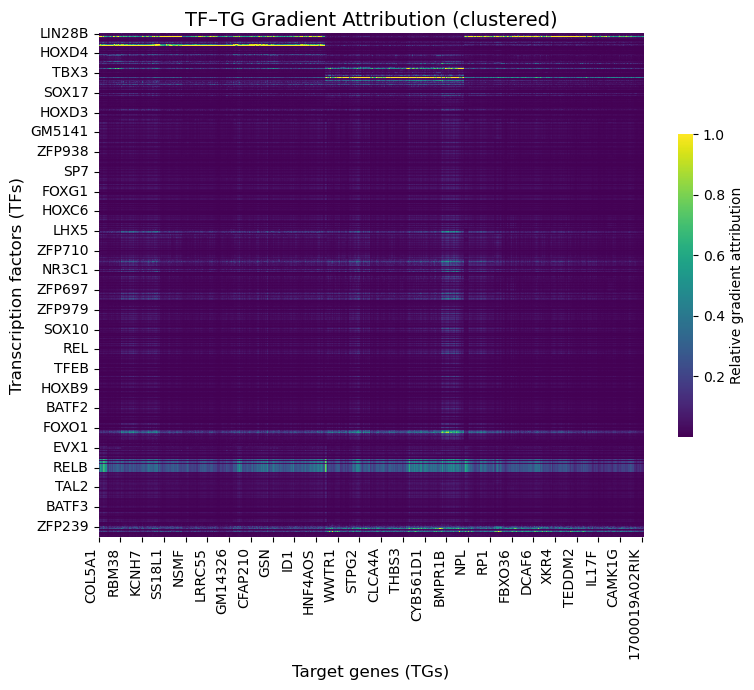

In [ ]:
import seaborn as sns
from matplotlib.colors import LogNorm

id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")

tf_names = list(id2name["tf_id2name"])
tg_names = list(id2name["tg_id2name"])

gradient_attribution = np.load(SELECTED_EXPERIMENT_DIR / "tf_tg_grad_attribution.npy")
gradient_attribution_df = pd.DataFrame(
    gradient_attribution,
    index=tf_names,
    columns=tg_names
)

nonzero = (gradient_attribution > 0)
print("Nonzero cells:", nonzero.sum(), "out of", gradient_attribution.size)

T_total = len(tf_names)
G_total = len(tg_names)

# number of TFs/TGs with any nonzero attribution
tf_nonzero = (gradient_attribution > 0).any(axis=1)
tg_nonzero = (gradient_attribution > 0).any(axis=0)
print("TFs with any signal:", tf_nonzero.sum(), "/", T_total)
print("TGs with any signal:", tg_nonzero.sum(), "/", G_total)

tf_keep = [name for name, nz in zip(tf_names, tf_nonzero) if nz]
tg_keep = [name for name, nz in zip(tg_names, tg_nonzero) if nz]

df_dense = gradient_attribution_df.loc[tf_keep, tg_keep]

df_col_norm = df_dense.div(df_dense.max(axis=0) + 1e-12, axis=1)

data = df_col_norm.copy()

# First: run clustermap JUST to compute clustering
g = sns.clustermap(
    data,
    metric="correlation",      # or "euclidean"
    method="average",          # or "ward", "complete", ...
    cmap="viridis",
    row_cluster=True,
    col_cluster=True,
    standard_scale=None,       # don't rescale, you already did
    figsize=(8, 8),
    xticklabels=False,         # we’ll add labels later
    yticklabels=False,
    cbar_pos=None,             # no colorbar here
)

# Get clustered order of rows/cols
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

plt.close(g.figure)  # close the clustermap figure; we just needed the order

# Reorder your matrix
data_reordered = data.iloc[row_order, col_order]

fig, ax = plt.subplots(figsize=(8, 7))

# Plot heatmap
im = sns.heatmap(
    data_reordered,
    ax=ax,
    cmap="viridis",
    cbar=True,
    cbar_kws={"shrink": 0.6, "label": "Relative gradient attribution"},
)

# Formatting: ticks, fonts, rotation
ax.set_xlabel("Target genes (TGs)", fontsize=12)
ax.set_ylabel("Transcription factors (TFs)", fontsize=12)
ax.set_title("TF–TG Gradient Attribution (clustered)", fontsize=14)

n_cols = data_reordered.shape[1]
max_labels = 25

step_x = max(1, n_cols // max_labels)
x_idx = np.arange(0, n_cols, step_x)          # column indices to label

ax.set_xticks(x_idx + 0.5)                    # centers of cells
ax.set_xticklabels(
    data_reordered.columns[x_idx],
    rotation=90,
    ha="right",
    fontsize=10,
)

n_rows = data_reordered.shape[0]
step_y = max(1, n_rows // max_labels)
y_idx = np.arange(0, n_rows, step_y)

ax.set_yticks(y_idx + 0.5)
ax.set_yticklabels(
    data_reordered.index[y_idx],
    fontsize=10,
)

plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_gradient_attribution_clustermap.png", dpi=300)
plt.show()

Gradient edges available: 4378428
Total ChIP edges in file: 977841
ChIP edges with TF+TG in grad matrix: 54239
Unique TFs in GT & grad: 34
Unique TGs in GT & grad: 6041
Overall GT fraction (grad): 0.012387779358253692
[Gradient, ChIP TFs only] GT fraction: 0.23281738264482676
Balanced: 108478 pairs (pos=54239, neg=54239)
[Gradient TF→TG] AUROC = 0.5174, AUPRC = 0.5270


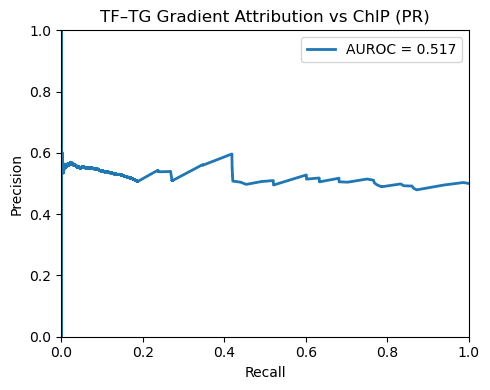

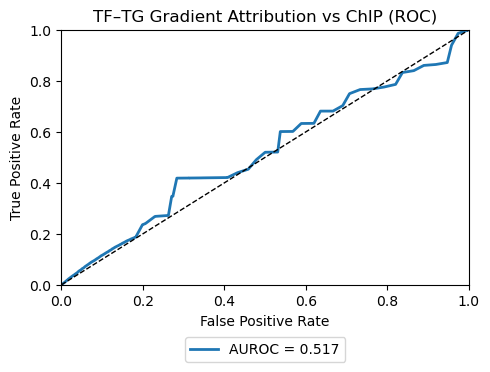

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score

# ---------- 1) Load gradient attribution and preprocess ----------
grad = np.load(SELECTED_EXPERIMENT_DIR / "tf_tg_grad_attribution.npy")  # [T, G]

# Load TF/TG names
id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
tf_names = list(id2name["tf_id2name"])
tg_names = list(id2name["tg_id2name"])

T, G = grad.shape
assert T == len(tf_names) and G == len(tg_names)

# Optional: use positive part + row-wise z-score, like for knockout
grad_pos = np.clip(grad, 0, None)          # negatives → 0, NaNs stay NaN
grad_pos = np.nan_to_num(grad_pos, nan=0.) # if any NaNs, treat as 0 for stats

row_mean = grad_pos.mean(axis=1, keepdims=True)
row_std  = grad_pos.std(axis=1, keepdims=True) + 1e-6
grad_z   = (grad_pos - row_mean) / row_std   # [T, G]

# ---------- 2) Build TF–TG DataFrame with gradient scores ----------
tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

df_grad = pd.DataFrame({
    "tf": np.array(tf_names, dtype=object)[tf_idx.ravel()],
    "tg": np.array(tg_names, dtype=object)[tg_idx.ravel()],
    "score_grad_z": grad_z.ravel(),
})

df_grad["tf"] = df_grad["tf"].astype(str).str.upper()
df_grad["tg"] = df_grad["tg"].astype(str).str.upper()

# Clean up weird values if any
df_grad = df_grad.replace([np.inf, -np.inf], np.nan)
df_grad = df_grad.dropna(subset=["score_grad_z"]).reset_index(drop=True)

print("Gradient edges available:", len(df_grad))

# ---------- 3) Attach ChIP labels ----------
chip = ground_truth_df.copy()

print("Total ChIP edges in file:", len(chip))

# Limit ChIP to TF/TG present in gradient matrix
tf_set = set(df_grad["tf"].unique())
tg_set = set(df_grad["tg"].unique())
chip_valid = chip[chip["tf"].isin(tf_set) & chip["tg"].isin(tg_set)].copy()

print("ChIP edges with TF+TG in grad matrix:", len(chip_valid))
print("Unique TFs in GT & grad:", chip_valid["tf"].nunique())
print("Unique TGs in GT & grad:", chip_valid["tg"].nunique())

gt_set = set(zip(chip_valid["tf"], chip_valid["tg"]))
df_grad["is_gt"] = list(map(gt_set.__contains__, zip(df_grad["tf"], df_grad["tg"])))
print("Overall GT fraction (grad):", df_grad["is_gt"].mean())

# Restrict to TFs that appear in ChIP (to match other methods)
chip_tf_set = set(chip_valid["tf"].unique())
df_grad_chip_tf = df_grad[df_grad["tf"].isin(chip_tf_set)].copy()
print("[Gradient, ChIP TFs only] GT fraction:", df_grad_chip_tf["is_gt"].mean())

# ---------- 4) Use your existing balancing helper ----------
def balance_pos_neg(df, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0):
    rng = np.random.default_rng(random_state)
    pos_df = df[df[label_col] == True]
    neg_df = df[df[label_col] == False]

    n_pos = len(pos_df)
    if n_pos == 0:
        print("No positives, skipping balance")
        return df.copy()

    n_neg_desired = min(int(n_pos * pos_to_neg_ratio), len(neg_df))
    neg_idx = rng.choice(neg_df.index.to_numpy(), size=n_neg_desired, replace=False)
    neg_sample = neg_df.loc[neg_idx]

    balanced = pd.concat([pos_df, neg_sample], axis=0)
    balanced = balanced.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    print(f"Balanced: {len(balanced)} pairs (pos={len(pos_df)}, neg={len(neg_sample)})")
    return balanced

df_grad_bal = balance_pos_neg(df_grad_chip_tf, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0)

# ---------- 5) Evaluate (standalone) ----------
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

labels = df_grad_bal["is_gt"].astype(int).values
scores = df_grad_bal["score_grad_z"].values

auroc_grad = roc_auc_score(labels, scores)
auprc_grad = average_precision_score(labels, scores)
print(f"[Gradient TF→TG] AUROC = {auroc_grad:.4f}, AUPRC = {auprc_grad:.4f}")

# PR curve
prec, rec, _ = precision_recall_curve(labels, scores)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, lw=2, label=f"AUROC = {auroc_grad:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("TF–TG Gradient Attribution vs ChIP (PR)")
plt.legend()
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_gradient_pr_curve.png", dpi=200)
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(labels, scores)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUROC = {auroc_grad:.3f}")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TF–TG Gradient Attribution vs ChIP (ROC)")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.33))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_gradient_roc_curve.png", dpi=200)
plt.show()


## Shortcut Matrix

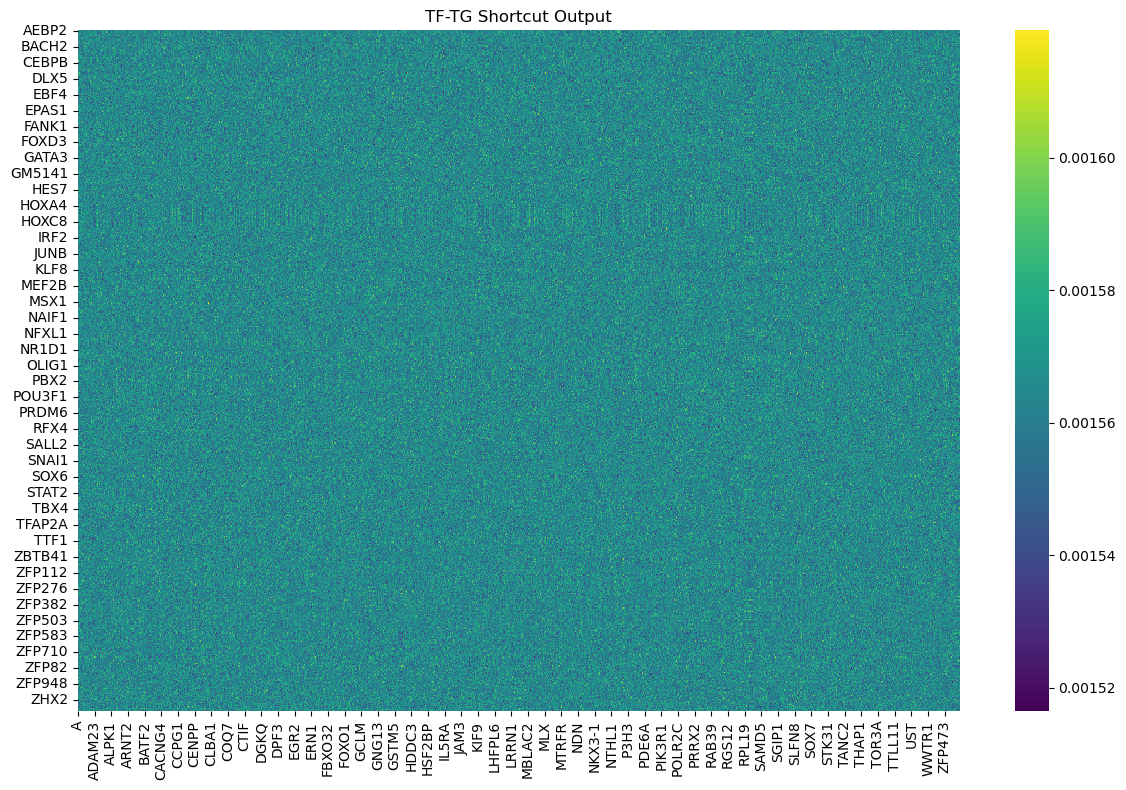

In [ ]:
model, test_loader, tg_scaler, tf_scaler = load_model("trained_model.pt")

model.eval()
device = next(model.parameters()).device

T = model.tf_identity_emb.num_embeddings
G = model.tg_identity_emb.num_embeddings

# identity embeddings for all TFs and TGs
tf_ids = torch.arange(T, device=device, dtype=torch.long)
tg_ids = torch.arange(G, device=device, dtype=torch.long)
tf_id_emb = model.tf_identity_emb(tf_ids)      # [T, d_model]
tg_emb    = model.tg_identity_emb(tg_ids)      # [G, d_model]

# dummy TF expression: attention doesn't depend on this
tf_expr_dummy = torch.ones(1, T, device=device)

# optional motif mask if you use it (shape [G, T]); else None
motif_mask_full = None   # or load the same mask you used in training

with torch.no_grad():
    _, attn_full = model.shortcut_layer(
        tg_emb,           # [G, d_model]
        tf_id_emb,        # [T, d_model]
        tf_expr_dummy,    # [1, T]
        motif_mask=motif_mask_full,
    )

shortcut_matrix = attn_full.cpu().numpy().T    # [T, G]
shortcut_matrix_df = pd.DataFrame(shortcut_matrix, index=tf_names, columns=tg_names)

df_subset = shortcut_matrix_df.loc[
    [idx for idx in shortcut_matrix_df.index if len(str(idx)) < 7],      # row filter
    [col for col in shortcut_matrix_df.columns if len(str(col)) < 7]    # column filter
]
plt.figure(figsize=(12,8))
sns.heatmap(df_subset, cmap="viridis")
plt.title("TF-TG Shortcut Output")
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_shortcut_weight_heatmap.png", dpi=300)
plt.show()


## TF Ablation Importance

### Submit TF ablation job

In [66]:
def submit_tf_ablation_job(project_root, selected_experiment_dir):
    import subprocess
    from pathlib import Path
    import textwrap

    job_script = textwrap.dedent(f"""\
    #!/bin/bash -l
    #SBATCH --job-name=tf_ablation
    #SBATCH --output=LOGS/transformer_logs/04_testing/%x_%A_%a.log
    #SBATCH --error=LOGS/transformer_logs/04_testing/%x_%A_%a.err
    #SBATCH --time=12:00:00
    #SBATCH -p dense
    #SBATCH -N 1
    #SBATCH --gres=gpu:v100:1
    #SBATCH --ntasks-per-node=1
    #SBATCH -c 8
    #SBATCH --mem=64G

    set -euo pipefail

    echo "Host: $(hostname)"
    echo "CUDA_VISIBLE_DEVICES: ${{CUDA_VISIBLE_DEVICES:-unset}}"
    echo "SLURM_JOB_ID: $SLURM_JOB_ID"

    cd "{project_root}"
    source .venv/bin/activate

    export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True,max_split_size_mb:32
    export OMP_NUM_THREADS=8
    export MKL_NUM_THREADS=8
    export OPENBLAS_NUM_THREADS=8
    export NUMEXPR_NUM_THREADS=8
    export BLIS_NUM_THREADS=8
    export KMP_AFFINITY=granularity=fine,compact,1,0

    SELECTED_EXPERIMENT_DIR="{selected_experiment_dir}"

    poetry run python ./dev/grad_attrib.py \\
        --selected_experiment_dir "$SELECTED_EXPERIMENT_DIR"

    echo "finished successfully!"
    """)

    script_path = Path(project_root) / "dev" /"run_grad_attrib.sh"
    script_path.write_text(job_script)

    result = subprocess.run(
        ["sbatch", str(script_path)],
        cwd=project_root,
        capture_output=True,
        text=True,
    )

    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)

override = False
if not os.path.isfile(SELECTED_EXPERIMENT_DIR / "tf_tg_fullmodel_knockout.npy") or override:
    submit_tf_ablation_job(PROJECT_DIR, SELECTED_EXPERIMENT_DIR)

STDOUT: Submitted batch job 3415086

STDERR: 


### Load ablation results

In [ ]:
effect = np.load(SELECTED_EXPERIMENT_DIR / "tf_tg_fullmodel_knockout.npy")  # [T, G]
counts = np.load(SELECTED_EXPERIMENT_DIR / "tf_tg_fullmodel_knockout_count.npy")  # [T, G]

mask_observed = counts > 0

# Keep NaN for unseen edges
effect[~mask_observed] = np.nan

# Positive-only effect
effect_pos = np.clip(effect, 0, None)  # NaNs stay NaN

# Row-wise z-score *ignoring* NaNs
row_mean = np.nanmean(effect_pos, axis=1, keepdims=True)
row_std  = np.nanstd(effect_pos, axis=1, keepdims=True) + 1e-6
knockout_z = (effect_pos - row_mean) / row_std  # still NaN for unseen edges

# Load names
id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
tf_names = list(id2name["tf_id2name"])
tg_names = list(id2name["tg_id2name"])

T, G = knockout_z.shape
tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

df_knockout = pd.DataFrame({
    "tf": np.array(tf_names, dtype=object)[tf_idx.ravel()],
    "tg": np.array(tg_names, dtype=object)[tg_idx.ravel()],
    "knockout_z": knockout_z.ravel(),
})
df_knockout["tf"] = df_knockout["tf"].astype(str).str.upper()
df_knockout["tg"] = df_knockout["tg"].astype(str).str.upper()

# Drop unseen edges (NaN)
df_knockout = df_knockout.dropna(subset=["knockout_z"]).reset_index(drop=True)
print("Number of edges with observed knockout effect:", len(df_knockout))

Number of edges with observed knockout effect: 865845


### Ablation - ChIP

Total ChIP edges in file: 977841
ChIP edges with TF+TG in vocab: 10716
Unique TFs in GT & vocab: 31
Unique TGs in GT & vocab: 1193
Overall GT fraction: 0.012376349115603832
[ChIP TFs only] GT fraction: 0.25511248660873703
Balanced: 21432 pairs (pos=10716, neg=10716)
[Knockout TF→TG] AUROC = 0.5501, AUPRC = 0.5437


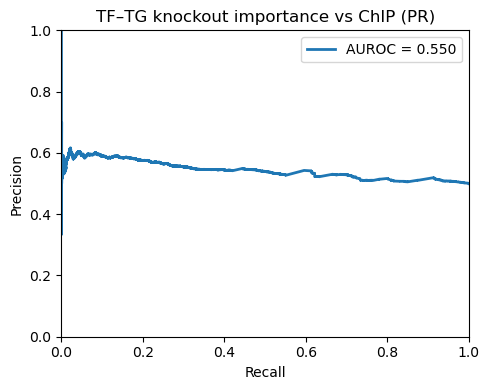

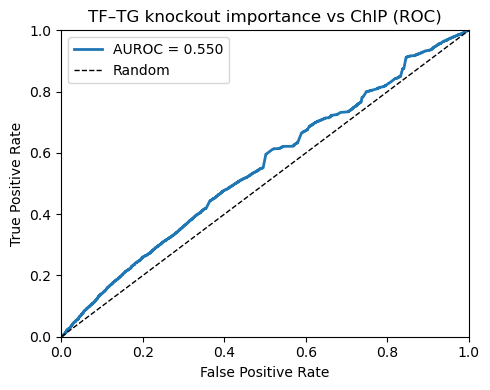

 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
    0.900   0.820320   2144     0.585354     19288        0.490512         1.193353
    0.950   1.720020   1072     0.583955     20360        0.495580         1.178328
    0.990   4.491050    215     0.548837     21217        0.499505         1.098762
    0.995   6.101265    108     0.564815     21324        0.499672         1.130372
Overall TF–TG coverage (fraction with at least one ablation): 0.19775248102743725
Coverage among ChIP TF/TG pairs: 1.0


In [ ]:

# -------------------------
# Load ChIP and create labels
# -------------------------
chip = ground_truth_df.copy()

print("Total ChIP edges in file:", len(chip))

# Limit to TF/TG in your vocab (optional but usually wise)
tf_set = set(df_knockout["tf"].unique())
tg_set = set(df_knockout["tg"].unique())
chip_valid = chip[chip["tf"].isin(tf_set) & chip["tg"].isin(tg_set)].copy()

print("ChIP edges with TF+TG in vocab:", len(chip_valid))
print("Unique TFs in GT & vocab:", chip_valid["tf"].nunique())
print("Unique TGs in GT & vocab:", chip_valid["tg"].nunique())

gt_set = set(zip(chip_valid["tf"], chip_valid["tg"]))

df_knockout["is_gt"] = list(map(gt_set.__contains__, zip(df_knockout["tf"], df_knockout["tg"])))
print("Overall GT fraction:", df_knockout["is_gt"].mean())

chip_tf_set = set(chip_valid["tf"].unique())
df_knockout_chip_tf = df_knockout[df_knockout["tf"].isin(chip_tf_set)].copy()
print("[ChIP TFs only] GT fraction:", df_knockout_chip_tf["is_gt"].mean())


def balance_pos_neg(df, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0):
    rng = np.random.default_rng(random_state)
    pos_df = df[df[label_col] == True]
    neg_df = df[df[label_col] == False]

    n_pos = len(pos_df)
    if n_pos == 0:
        print("No positives, skipping balance")
        return df.copy()

    n_neg_desired = min(int(n_pos * pos_to_neg_ratio), len(neg_df))
    neg_idx = rng.choice(neg_df.index.to_numpy(), size=n_neg_desired, replace=False)
    neg_sample = neg_df.loc[neg_idx]

    balanced = pd.concat([pos_df, neg_sample], axis=0)
    balanced = balanced.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    print(f"Balanced: {len(balanced)} pairs (pos={len(pos_df)}, neg={len(neg_sample)})")
    return balanced

df_bal = balance_pos_neg(df_knockout_chip_tf, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0)

labels = df_bal["is_gt"].astype(int).values
scores = df_bal["knockout_z"].values

auroc = roc_auc_score(labels, scores)
auprc = average_precision_score(labels, scores)
print(f"[Knockout TF→TG] AUROC = {auroc:.4f}, AUPRC = {auprc:.4f}")

# PR curve
prec, rec, _ = precision_recall_curve(labels, scores)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, lw=2, label=f"AUROC = {auroc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("TF–TG knockout importance vs ChIP (PR)")
plt.legend()
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_knockout_pr_curve.png", dpi=300)
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(labels, scores)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUROC = {auroc:.3f}")
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TF–TG knockout importance vs ChIP (ROC)")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(SELECTED_EXPERIMENT_DIR / "tf_tg_knockout_roc_curve.png", dpi=300)
plt.show()

def enrichment_by_quantile(df, score_col, quantiles=(0.9, 0.95, 0.99, 0.995)):
    rows = []
    for q in quantiles:
        thr = df[score_col].quantile(q)
        top = df[df[score_col] >= thr]
        bottom = df[df[score_col] < thr]
        top_gt = top["is_gt"].mean()
        bot_gt = bottom["is_gt"].mean()
        rows.append({
            "quantile": q,
            "threshold": float(thr),
            "top_n": int(len(top)),
            "top_gt_frac": float(top_gt),
            "bottom_n": int(len(bottom)),
            "bottom_gt_frac": float(bot_gt),
            "enrichment_fold": float(top_gt / (bot_gt + 1e-12)),
        })
    return pd.DataFrame(rows)

print(enrichment_by_quantile(df_bal, "knockout_z").to_string(index=False))

# Check gene coverage
coverage_all = (counts > 0).mean()
print("Overall TF–TG coverage (fraction with at least one ablation):", coverage_all)

tf_index = {g: i for i, g in enumerate(tf_names)}
tg_index = {g: i for i, g in enumerate(tg_names)}

chip_tf_idx = [tf_index[t] for t in chip_tf_set if t in tf_index]
chip_tg_idx = [tg_index[g] for g in chip_valid["tg"].unique() if g in tg_index]

coverage_chip = (counts[np.ix_(chip_tf_idx, chip_tg_idx)] > 0).mean()
print("Coverage among ChIP TF/TG pairs:", coverage_chip)



## Comparing Emb Similarity, Grad Attrib, Shortcut Weights, and Ablation

### Helper Functions

In [636]:
# Define Helper Functions
# ----------------------------------
from torch import rand


def balance_pos_neg(df, label_col="is_gt", pos_to_neg_ratio=1.0, random_state=0):
    rng = np.random.default_rng(random_state)
    pos_df = df[df[label_col]]
    neg_df = df[~df[label_col]]

    n_pos = len(pos_df)
    if n_pos == 0:
        print("No positives, skipping balance")
        return df.copy()

    n_neg_desired = min(int(n_pos * pos_to_neg_ratio), len(neg_df))
    neg_idx = rng.choice(neg_df.index.to_numpy(), size=n_neg_desired, replace=False)
    neg_sample = neg_df.loc[neg_idx]

    balanced = pd.concat([pos_df, neg_sample], axis=0)
    balanced = balanced.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    print(f"\t- Balanced: {len(balanced):,} edges ({len(pos_df):,} pos, {len(neg_sample):,} neg)")
    return balanced

def create_random_distribution(scores: pd.Series, seed: int = 42) -> np.ndarray:
    random.seed(seed)
    uniform_distribution = np.random.uniform(low = scores.min(), high = scores.max(), size = len(scores))
    resampled_scores = np.random.choice(uniform_distribution, size=len(scores), replace=True)
    return resampled_scores



def eval_method(df, score_col, label_col="is_gt", name="", balance=True):
    """Compute AUROC, AUPRC, PR and ROC curves for a given score column."""
    df = df.dropna(subset=[score_col]).copy()

    if balance:
        df_bal = balance_pos_neg(df, label_col=label_col, pos_to_neg_ratio=1.0, random_state=0)
    else:
        df_bal = df

    y = df_bal[label_col].astype(int).values
    s = df_bal[score_col].values
    
    fig, auroc, auprc = plot_auroc_auprc(df, name, score_col, label_col=label_col)
    
    fig.savefig(SELECTED_EXPERIMENT_DIR / f"{name.replace(' ', '_').lower()}_combined_roc_prc_curve.png", dpi=300)

    return fig, auroc, auprc

def compute_curves(df, score_col, label_col="is_gt", balance=True, name=""):
    """Return AUROC, AUPRC, and PR/ROC curves for one method."""
    df = df.dropna(subset=[score_col]).copy()
    
    if balance:
        df = balance_pos_neg(df, label_col=label_col, pos_to_neg_ratio=1.0, random_state=0)
    
    y = df[label_col].astype(int).values
    s = df[score_col].values

    auroc = roc_auc_score(y, s)
    auprc = average_precision_score(y, s)

    prec, rec, _ = precision_recall_curve(y, s)
    fpr, tpr, _ = roc_curve(y, s)

    return {
        "name": name,
        "auroc": auroc,
        "auprc": auprc,
        "prec": prec,
        "rec": rec,
        "fpr": fpr,
        "tpr": tpr,
    }
    
def plot_auroc_auprc(df, name, score_col, label_col="is_gt"):
    """_summary_

    Args:
        name (str): Dataset name
        score_col (str): Name of the score column
        label_col (str): Name of the label column

    Returns:
        tuple(plt.Figure, float, float): AUROC/AUPRC Figure, AUROC, AUPRC
    """
    
    df["random_scores"] = create_random_distribution(df[score_col])
    
    curves = compute_curves(df, score_col, label_col=label_col, balance=True, name=name)
    rand_curves = compute_curves(df, "random_scores", label_col=label_col, balance=True, name=name)
    
    auroc = curves["auroc"]
    auprc = curves["auprc"]
    prec = curves["prec"]
    rec = curves["rec"]
    fpr = curves["fpr"]
    tpr = curves["tpr"]
    
    rand_auroc = rand_curves["auroc"]
    rand_auprc = rand_curves["auprc"]
    rand_prec = rand_curves["prec"]
    rand_rec = rand_curves["rec"]
    rand_fpr = rand_curves["fpr"]
    rand_tpr = rand_curves["tpr"]
    
    # ROC plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    ax[0].plot(rand_fpr, rand_tpr, color="#7ab4e8", linestyle="--", lw=2)
    ax[0].plot(fpr, tpr, lw=2, color="#4195df", label=f"AUROC = {auroc:.3f}\nRandom = {rand_auroc:.3f}")
    ax[0].plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title(f"AUROC")
    ax[0].legend(
        bbox_to_anchor=(0.5, -0.28),
        loc="upper center",
        borderaxespad=0.0
    )
    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)
    
    # PR plot
    ax[1].plot(rand_rec, rand_prec, color="#7ab4e8", linestyle="--", lw=2)
    ax[1].plot(rec, prec, lw=2, color="#4195df", label=f"AUPRC = {auprc:.3f}\nRandom = {rand_auprc:.3f}")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title(f"AUPRC")
    ax[1].legend(
        bbox_to_anchor=(0.5, -0.28),
        loc="upper center",
        borderaxespad=0.0
    )
    ax[1].set_ylim(0, 1.0)
    ax[1].set_xlim(0, 1.0)
    plt.suptitle(name, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig, auroc, auprc

def matrix_to_df(mat, tf_names, tg_names, colname):
    """Flatten [T, G] matrix into (tf, tg, score) df."""
    T, G = mat.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")
    df = pd.DataFrame({
        "tf": np.array(tf_names, dtype=object)[tf_idx.ravel()],
        "tg": np.array(tg_names, dtype=object)[tg_idx.ravel()],
        colname: mat.ravel(),
    })
    df["tf"] = df["tf"].astype(str).str.upper()
    df["tg"] = df["tg"].astype(str).str.upper()
    return df

def make_label_df_universe(tf_names, tg_names):
    T, G = len(tf_names), len(tg_names)
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")
    df = pd.DataFrame({
        "tf": np.array(tf_names, dtype=object)[tf_idx.ravel()],
        "tg": np.array(tg_names, dtype=object)[tg_idx.ravel()],
    })
    df["tf"] = df["tf"].astype(str).str.upper()
    df["tg"] = df["tg"].astype(str).str.upper()
    df["is_gt"] = list(map(gt_set.__contains__, zip(df["tf"], df["tg"])))
    # only ChIP TFs
    df = df[df["tf"].isin(chip_tf_set)].reset_index(drop=True)
    print("Label universe size (ChIP TFs only):", len(df),
          "GT fraction:", df["is_gt"].mean())
    return df






In [637]:
def _canonicalize_name(s):
    # leave missing values as-is
    if s is None or (isinstance(s, float) and math.isnan(s)):
        return s
    # normal string case
    if isinstance(s, str):
        return s.strip()
    # anything else → convert to string and strip
    return str(s).strip()

def _compute_roc_auc(y_true, scores):
    """
    Minimal ROC/AUC for binary labels y_true in {0,1} and real-valued scores.
    Returns fpr, tpr, auc.
    """
    y_true = np.asarray(y_true, dtype=np.int8)
    scores = np.asarray(scores, dtype=np.float64)

    # sort by descending score
    order = np.argsort(-scores)
    y = y_true[order]

    P = y.sum()
    N = len(y) - P
    if P == 0 or N == 0:
        return np.array([0, 1]), np.array([0, 1]), np.nan

    # cumulative TP/FP as we move threshold down
    tp = np.cumsum(y)
    fp = np.cumsum(1 - y)

    tpr = tp / P
    fpr = fp / N

    # prepend (0,0)
    tpr = np.concatenate([[0.0], tpr])
    fpr = np.concatenate([[0.0], fpr])

    # trapezoidal AUC
    auc = np.trapezoid(tpr, fpr)  # or np.trapz(tpr, fpr) if needed
    return fpr, tpr, auc

# ----------------- generic "ChIP TFs only, by-quantile" function -----------------

def plot_chiptf_metric_auroc_by_quantile_from_scores(
    df,
    score_col,
    metric_name="scores",
    quantile_step=0.02,
    cmap_name="viridis",
):
    """
    Plot ROC curves and AUROC vs score quantile for a given method,
    using a long-form DataFrame with an 'is_gt' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain at least:
            - score_col : float scores
            - "is_gt"   : boolean, True for ChIP edge, False otherwise
        You should already have restricted df to the universe you care about
        (e.g., ChIP TFs only) before calling this function.
    score_col : str
        Name of the column in df containing the scores for the method.
    metric_name : str
        Name to use in printouts and plot titles.
    quantile_step : float
        Step size for quantiles (e.g. 0.02).
    cmap_name : str
        Matplotlib colormap name.
    """

    # Drop missing scores
    df_use = df.dropna(subset=[score_col]).copy()
    
    df_use = balance_pos_neg(df=df_use, label_col="is_gt")

    scores = df_use[score_col].to_numpy(dtype=float)
    y = df_use["is_gt"].astype(int).to_numpy()

    # Filter out any non-finite scores
    finite_mask = np.isfinite(scores)
    scores = scores[finite_mask]
    y = y[finite_mask]

    if len(scores) == 0:
        raise ValueError(f"[{metric_name}] No valid scores to evaluate.")

    overall_frac = y.mean()

    # ----- ROC curves by quantile subset -----
    quantiles = np.arange(0.96, 0.04, -quantile_step)
    cmap = plt.get_cmap(cmap_name)

    fig_roc, ax_roc = plt.subplots(figsize=(6, 5))

    qs_used = []
    auc_scores = []
    random_auc_scores = []
    
    for i, q in enumerate(quantiles):
        thr = np.quantile(scores, q)
        mask = scores >= thr
        y_sub = y[mask]
        s_sub = scores[mask]
        
        if len(s_sub) < 100:
            continue
        
        # skip degenerate subsets
        if len(y_sub) == 0 or y_sub.sum() == 0 or y_sub.sum() == len(y_sub):
            continue

        fpr, tpr, auc = _compute_roc_auc(y_sub, s_sub)

        t = float(i) / max(1, len(quantiles) - 1)
        color = cmap(1.0 - t)
        ax_roc.plot(fpr, tpr, color=color, lw=1.5, alpha=0.7)

        qs_used.append(q)
        auc_scores.append(auc)

    qs_used = np.array(qs_used)
    auc_scores = np.array(auc_scores)

    best_idx = np.nanargmax(auc_scores)
    best_auc = float(auc_scores[best_idx])
    best_q   = float(qs_used[best_idx])
    print(f"\t- {metric_name} Best AUROC {best_auc:.4f} above quantile {best_q:.3f}")

    # diagonal baseline
    ax_roc.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)

    ax_roc.set_xlim(0, 1)
    ax_roc.set_ylim(0, 1)
    ax_roc.set_xlabel("False positive rate")
    ax_roc.set_ylabel("True positive rate")
    ax_roc.set_title(f"ROC by score quantile ({metric_name})")

    ax_roc.text(
        1.02, 0.5,
        f"Best AUROC = {best_auc:.3f}\nQuantile ≥ {best_q:.2f}",
        transform=ax_roc.transAxes,
        va="center",
        ha="left",
        clip_on=False,
    )

    plt.tight_layout()

    # ----- BEST AUROC subset -----
    best_thr = np.quantile(scores, best_q)
    best_mask = scores >= best_thr
    y_best = y[best_mask]
    s_best = scores[best_mask]

    auc_prc_plot, auc_best, auprc_best = plot_auroc_auprc(df=df_use[best_mask], name="", score_col=score_col, label_col="is_gt")
    
    fpr_best, tpr_best, auc_best = _compute_roc_auc(y_best, s_best)

    auc_prc_plot.suptitle(
        f"Best Quantile ROC\n{metric_name}, q ≥ {best_q:.2f}, AUC={auc_best:.3f}"
    )
    plt.show()

    # ----- AUROC vs quantile figure -----
    fig_auc, ax_auc = plt.subplots(figsize=(5, 4))
    ax_auc.plot(qs_used, auc_scores, marker="o")
    ax_auc.axhline(0.5, linestyle="--", linewidth=1, color="gray", alpha=0.7)

    ax_auc.set_xlabel("Score quantile q (keep scores ≥ quantile(q))")
    ax_auc.set_ylabel("AUROC within subset")
    ax_auc.set_title(f"AUROC vs score quantile ({metric_name})")

    # highlight best point
    ax_auc.scatter([best_q], [best_auc], color="red", zorder=5, label="Best")
    ax_auc.legend()

    finite_auc = np.isfinite(auc_scores)
    if finite_auc.any():
        ymin = max(0.0, np.nanmin(auc_scores) - 0.05)
        ymax = min(1.0, np.nanmax(auc_scores) + 0.05)
        ax_auc.set_ylim(ymin, ymax)

    plt.tight_layout()

    return fig_roc, fig_auc, fig_best, best_auc, best_q


In [638]:
# ---- Load vocab ----
id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
tf_names = list(id2name["tf_id2name"])
tg_names = list(id2name["tg_id2name"])

# ---- Load ChIP ----
chip = ground_truth_df.copy()
print("Total ChIP edges in file:", len(chip))

tf_set_vocab = set([t.upper() for t in tf_names])
tg_set_vocab = set([g.upper() for g in tg_names])

chip_valid = chip[chip["tf"].isin(tf_set_vocab) & chip["tg"].isin(tg_set_vocab)].copy()
print("ChIP edges with TF+TG in vocab:", len(chip_valid))
print("Unique TFs in GT & vocab:", chip_valid["tf"].nunique())
print("Unique TGs in GT & vocab:", chip_valid["tg"].nunique())

gt_set = set(zip(chip_valid["tf"], chip_valid["tg"]))
chip_tf_set = set(chip_valid["tf"].unique())

label_df = make_label_df_universe(tf_names, tg_names)


Total ChIP edges in file: 1018410
ChIP edges with TF+TG in vocab: 64306
Unique TFs in GT & vocab: 44
Unique TGs in GT & vocab: 6187
Label universe size (ChIP TFs only): 301488 GT fraction: 0.20990885209361568


### Load TF-TG Similarity

In [639]:
# ---- Cosine similarity matrix ----
emb = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings_final.pt", map_location="cpu")
tf_emb = emb["tf_emb"]   # [T, d]
tg_emb = emb["tg_emb"]   # [G, d]

tf_norm = F.normalize(tf_emb, p=2, dim=1)
tg_norm = F.normalize(tg_emb, p=2, dim=1)
sim = (tf_norm @ tg_norm.T).cpu().numpy()   # [T, G]

# Optional: row-wise z-score per TF
mu = sim.mean(axis=1, keepdims=True)
sigma = sim.std(axis=1, keepdims=True) + 1e-6
cosine_z = (sim - mu) / sigma

df_cos = matrix_to_df(cosine_z, tf_names, tg_names, "score_cosine_z")

# merge with label universe
df_cos = label_df.merge(df_cos, on=["tf", "tg"], how="left")
print(df_cos.head())
print("Cosine df size:", len(df_cos))


      tf             tg  is_gt  score_cosine_z
0  AEBP2  0610005C13RIK  False        0.700703
1  AEBP2  0610009E02RIK  False        0.695973
2  AEBP2  0610030E20RIK   True       -0.230544
3  AEBP2  1110002J07RIK  False       -2.421824
4  AEBP2  1110019D14RIK  False        0.667991
Cosine df size: 301488


### Load TF-TG Shortcut Attention

In [640]:

def get_shortcut_edge_scores(model, device, motif_mask=None):
    model.eval()
    with torch.no_grad():
        T = model.tf_identity_emb.num_embeddings
        G = model.tg_identity_emb.num_embeddings

        tf_ids = torch.arange(T, device=device, dtype=torch.long)
        tg_ids = torch.arange(G, device=device, dtype=torch.long)

        tf_id_emb = model.tf_identity_emb(tf_ids)    # [T, d]
        tg_emb    = model.tg_identity_emb(tg_ids)    # [G, d]

        dummy_tf_expr = torch.ones(1, T, device=device)

        if motif_mask is not None:
            motif_mask = motif_mask.to(device)

        _, attn = model.shortcut_layer(
            tg_emb, tf_id_emb, dummy_tf_expr, motif_mask=motif_mask
        )  # attn: [G, T]

        scores = attn.T.cpu().numpy()  # [T, G]
    return scores

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model, test_loader, tg_scaler, tf_scaler = load_model("trained_model.pt", device)

shortcut_scores = get_shortcut_edge_scores(model, device)  # [T, G]

df_shortcut = matrix_to_df(shortcut_scores, tf_names, tg_names, "score_shortcut")
df_shortcut = label_df.merge(df_shortcut, on=["tf", "tg"], how="left")
print("Shortcut df size:", len(df_shortcut))

Shortcut df size: 301488


### Load TF-TG Gradient Attribution

In [641]:
# --- load names (you already did this above, but keeping it here for clarity) ---
id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
tf_names = list(id2name["tf_id2name"])
tg_names = list(id2name["tg_id2name"])

# --- load gradient attribution matrix ---
grad = np.load(SELECTED_EXPERIMENT_DIR / "tf_tg_grad_attribution.npy")  # shape [T, G]
assert grad.shape == (len(tf_names), len(tg_names))

# Optional: handle NaNs
grad = np.nan_to_num(grad, nan=0.0)

# Use absolute gradient magnitude as importance
grad_abs = np.abs(grad)

# Row-wise z-score per TF (ignore NaNs if you keep them)
row_mean = grad_abs.mean(axis=1, keepdims=True)
row_std  = grad_abs.std(axis=1, keepdims=True) + 1e-6
grad_z = (grad_abs - row_mean) / row_std   # [T, G]

# Build long-form dataframe
T, G = grad_z.shape
tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

df_grad = pd.DataFrame({
    "tf": np.array(tf_names, dtype=object)[tf_idx.ravel()],
    "tg": np.array(tg_names, dtype=object)[tg_idx.ravel()],
    "score_grad_z": grad_z.ravel(),
})
df_grad["tf"] = df_grad["tf"].astype(str).str.upper()
df_grad["tg"] = df_grad["tg"].astype(str).str.upper()

# If chip_valid / gt_set already exist from your earlier code:
gt_set = set(zip(chip_valid["tf"], chip_valid["tg"]))
chip_tf_set = set(chip_valid["tf"].unique())

# Label edges
df_grad["is_gt"] = list(map(gt_set.__contains__, zip(df_grad["tf"], df_grad["tg"])))

# Restrict to TFs that appear in ChIP
df_grad_chip_tf = df_grad[df_grad["tf"].isin(chip_tf_set)].copy()
print("[Gradient, ChIP TFs only] GT fraction:", df_grad_chip_tf["is_gt"].mean())

[Gradient, ChIP TFs only] GT fraction: 0.20990885209361568


### Load TF-TG Knockout Importance

In [642]:
effect = np.load(SELECTED_EXPERIMENT_DIR / "tf_tg_fullmodel_knockout.npy")        # [T, G]
counts = np.load(SELECTED_EXPERIMENT_DIR / "tf_tg_fullmodel_knockout_count.npy")  # [T, G]

mask_observed = counts > 0
effect[~mask_observed] = np.nan

effect_pos = np.clip(effect, 0, None)  # positives only, NaN preserved
row_mean = np.nanmean(effect_pos, axis=1, keepdims=True)
row_std  = np.nanstd(effect_pos,  axis=1, keepdims=True) + 1e-6
knockout_z = (effect_pos - row_mean) / row_std

print("Overall coverage (fraction observed):", np.mean(mask_observed))

df_ko = matrix_to_df(knockout_z, tf_names, tg_names, "score_knockout_z")
df_ko = df_ko.dropna(subset=["score_knockout_z"]).reset_index(drop=True)

# merge with labels, but only where knockout is defined
df_ko = label_df.merge(df_ko, on=["tf", "tg"], how="inner")
print("Knockout df size (observed edges only):", len(df_ko))


Overall coverage (fraction observed): 0.19775248102743725
Knockout df size (observed edges only): 59620


In [643]:
methods = [
    ("TF-TG Embedding Similarity", df_cos.dropna(subset=["score_cosine_z"]), "score_cosine_z"),
    ("Shortcut attention", df_shortcut.dropna(subset=["score_shortcut"]), "score_shortcut"),
    ("TF Knockout ", df_ko, "score_knockout_z"),
    ("Gradient Attribution", df_grad_chip_tf, "score_grad_z")
]

### Overall AUROC / AUPRC

	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)


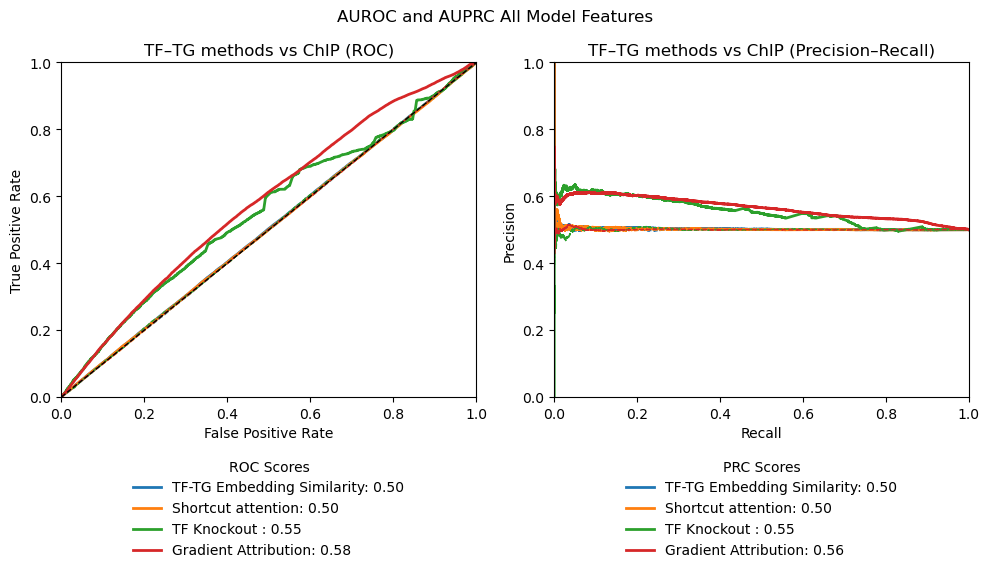

In [644]:

# -----------------------------
# Compute metrics for each method
# -----------------------------
results = []
rand_results = []
for name, df_m, score_col in methods:
    res = compute_curves(df_m, score_col=score_col, name=name)
    results.append(res)
    
    rand_res = compute_curves(
        df_m.assign(**{score_col: create_random_distribution(df_m[score_col])}),
        score_col=score_col,
        name=f"{name} (Randomized Scores)"
    )
    rand_results.append(rand_res)

# -----------------------------
# Plot PR curves on one figure
# -----------------------------
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

# AUROC for each method
for i, (res, color) in enumerate(zip(results, colors)):
    ax[0].plot(
        res["fpr"], res["tpr"],
        lw=2,
        color=color,
        label=f"{res['name']}: {res['auroc']:.2f}"
    )
    ax[0].plot(
        rand_results[i]["fpr"], rand_results[i]["tpr"],
        lw=1,
        color=color,
        linestyle="--",
    )
ax[0].plot([0, 1], [0, 1], "k--", lw=1)
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("TF–TG methods vs ChIP (ROC)")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].legend(
    title="ROC Scores",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    frameon=False,
    fontsize=10
)

# AUPRC for each method
for i, (res, color) in enumerate(zip(results, colors)):
    ax[1].plot(
        res["rec"], res["prec"],
        lw=2,
        color=color,
        label=f"{res['name']}: {res['auprc']:.2f}"
    )
    ax[1].plot(
        rand_results[i]["rec"], rand_results[i]["prec"],
        lw=1,
        color=color,
        linestyle="--",
    )

ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("TF–TG methods vs ChIP (Precision–Recall)")
ax[1].set_ylim(0, 1.0)
ax[1].set_xlim(0, 1.0)
ax[1].legend(
    title="PRC Scores",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    frameon=False,
    fontsize=10
)
plt.suptitle("AUROC and AUPRC All Model Features")
plt.tight_layout()
plt.show()

### Plot AUROC and AUPRC Plots for each Method

	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)


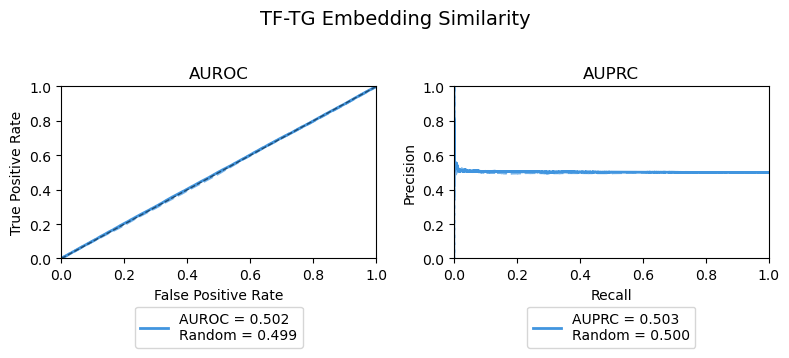

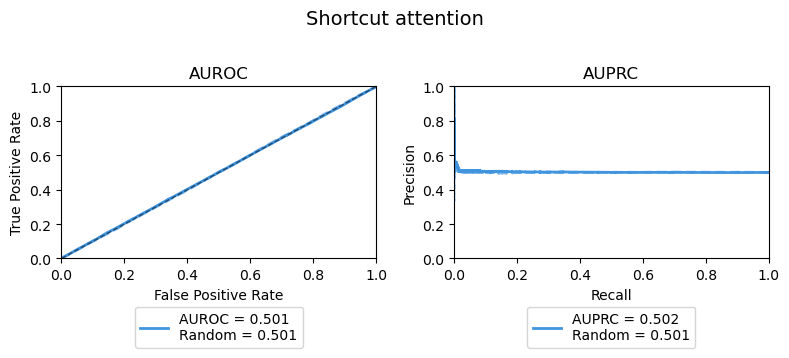

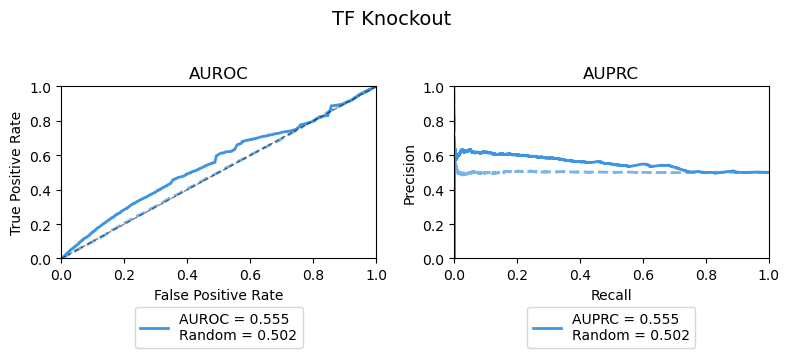

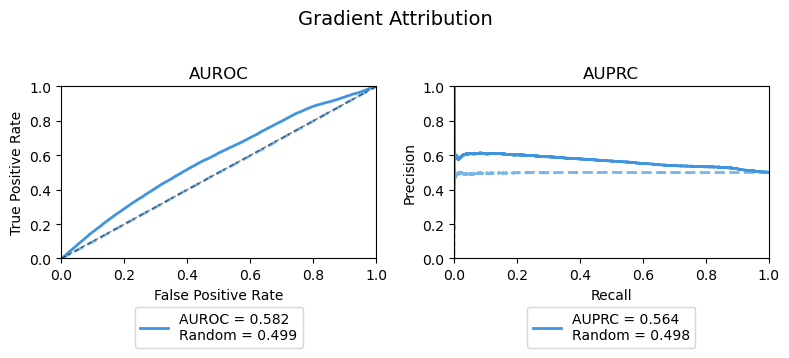

In [ ]:

for method_name, df_m, score_col in methods:
    auc_prc_plot, auroc, auprc = plot_auroc_auprc(df=df_m, name=method_name, score_col=score_col, label_col="is_gt")
    auc_prc_plot.show()

### Plot AUROC by Quantile

- **TF-TG Embedding Similarity:**
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- TF-TG Embedding Similarity Best AUROC 0.5108 above quantile 0.960
	- Balanced: 5,063 edges (2,572 pos, 2,491 neg)
	- Balanced: 5,063 edges (2,572 pos, 2,491 neg)


/tmp/ipykernel_3762917/1778483026.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["random_scores"] = create_random_distribution(df[score_col])


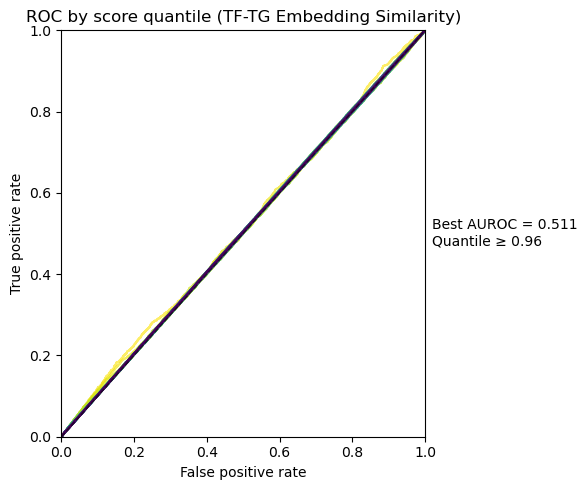

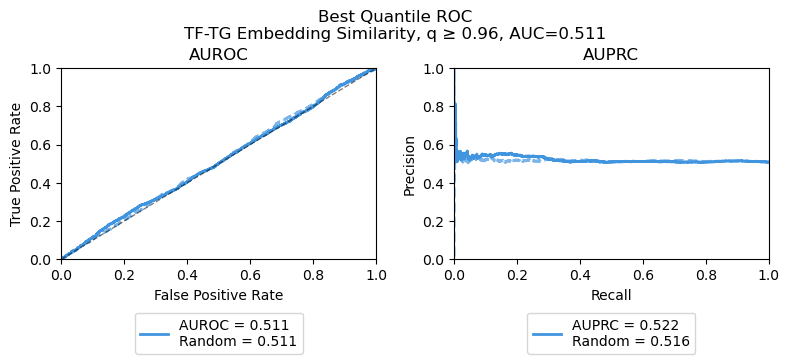

- **Shortcut attention:**
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Shortcut attention Best AUROC 0.5064 above quantile 0.960
	- Balanced: 5,063 edges (2,579 pos, 2,484 neg)
	- Balanced: 5,063 edges (2,579 pos, 2,484 neg)


/tmp/ipykernel_3762917/1778483026.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["random_scores"] = create_random_distribution(df[score_col])


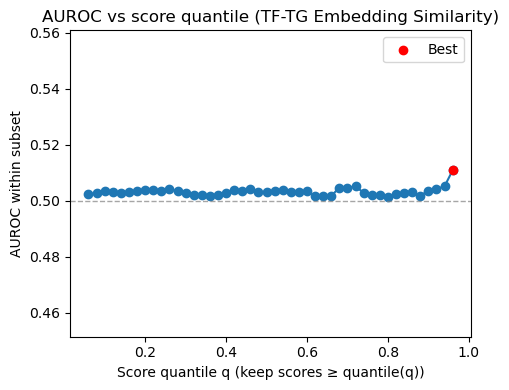

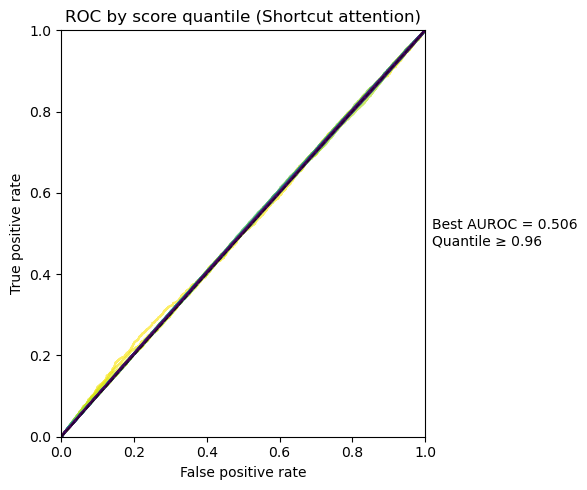

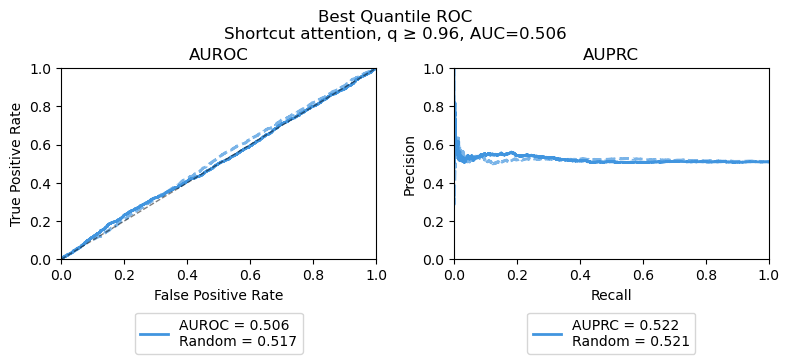

- **TF Knockout :**
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- TF Knockout  Best AUROC 0.5910 above quantile 0.260
	- Balanced: 18,600 edges (9,359 pos, 9,241 neg)
	- Balanced: 18,600 edges (9,359 pos, 9,241 neg)


/tmp/ipykernel_3762917/1778483026.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["random_scores"] = create_random_distribution(df[score_col])


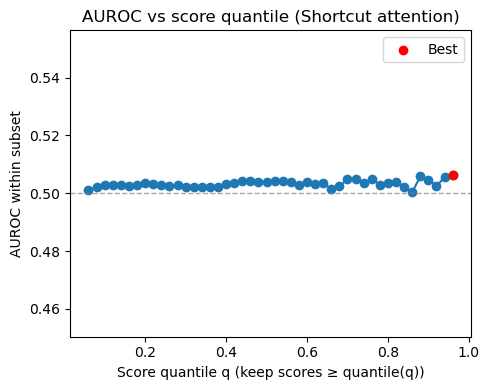

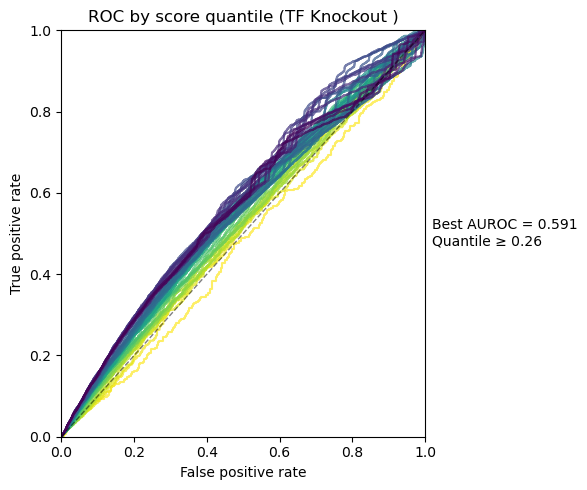

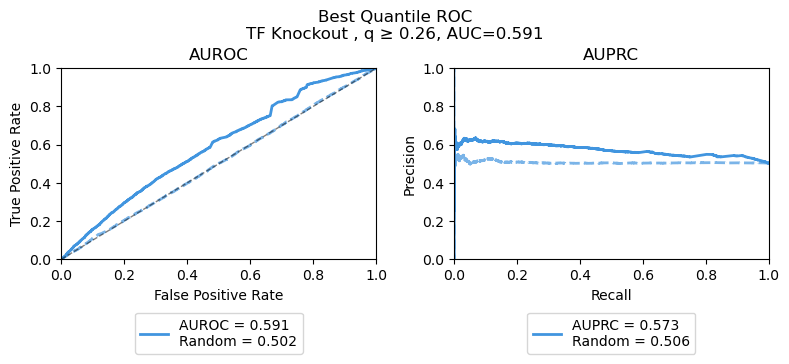

- **Gradient Attribution:**
	- Balanced: 126,570 edges (63,285 pos, 63,285 neg)
	- Gradient Attribution Best AUROC 0.5758 above quantile 0.060
	- Balanced: 118,975 edges (60,420 pos, 58,555 neg)
	- Balanced: 118,975 edges (60,420 pos, 58,555 neg)


/tmp/ipykernel_3762917/1778483026.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["random_scores"] = create_random_distribution(df[score_col])


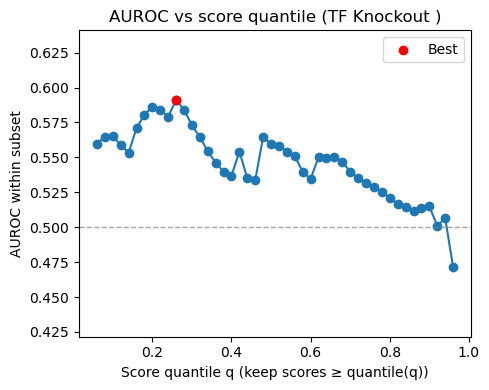

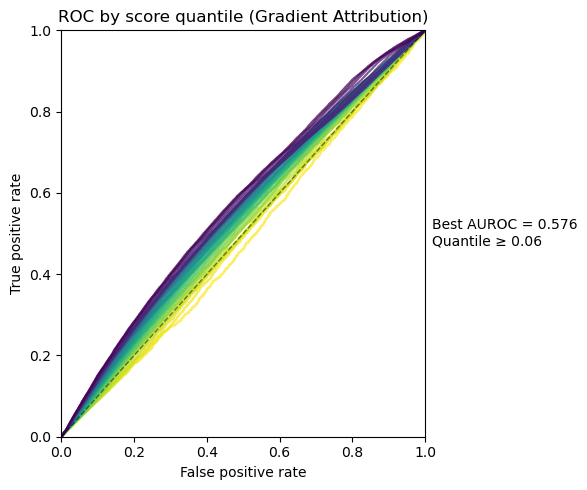

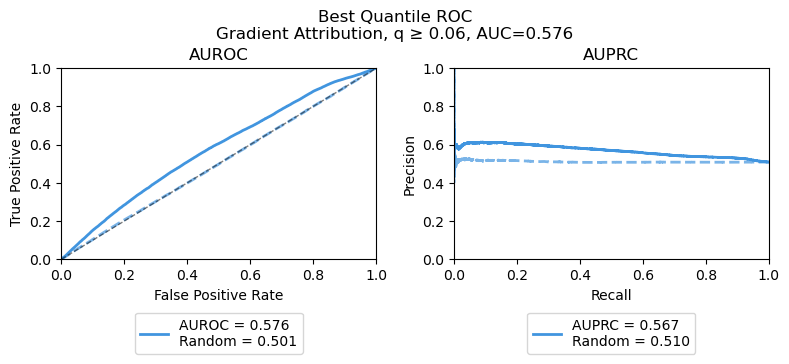

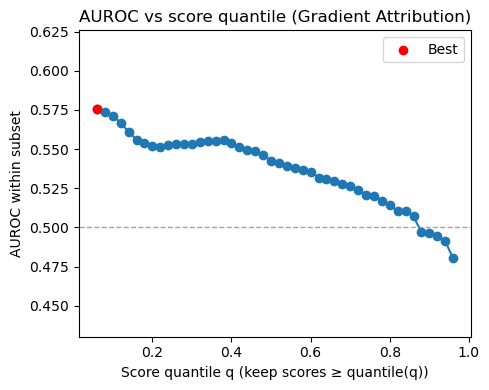

In [646]:
### Plot AUROC by Quantile
figs = {}

best_results = {}
for method_name, df_m, score_col in methods:
    print(f"- **{method_name}:**")
    fig_roc, fig_auc, fig_best, best_auc, best_q = plot_chiptf_metric_auroc_by_quantile_from_scores(
        df=df_m,
        score_col=score_col,
        metric_name=method_name,
        quantile_step=0.02,   # match your previous choice
        cmap_name="viridis",
    )
    
    if best_auc > 0.55:
        best_results[method_name] = [df_m, score_col, best_auc, best_q]

    # save figs
    safe_name = method_name.lower().replace(" ", "_")
    fig_roc.savefig(SELECTED_EXPERIMENT_DIR / f"chiptf_{safe_name}_roc_curves_by_quantile.png", dpi=300)
    fig_auc.savefig(SELECTED_EXPERIMENT_DIR / f"chiptf_{safe_name}_auc_score_by_quantile.png", dpi=300)
    fig_best.savefig(SELECTED_EXPERIMENT_DIR / f"chiptf_{safe_name}_best_roc_curve.png", dpi=300)

    fig_roc.show()
    fig_auc.show()
    fig_best.show()

    figs[method_name] = (fig_roc, fig_auc, fig_best)


### Combine Methods

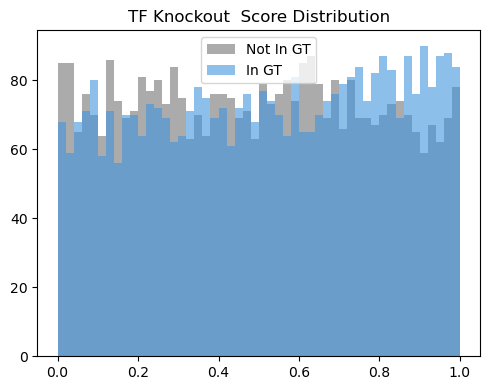

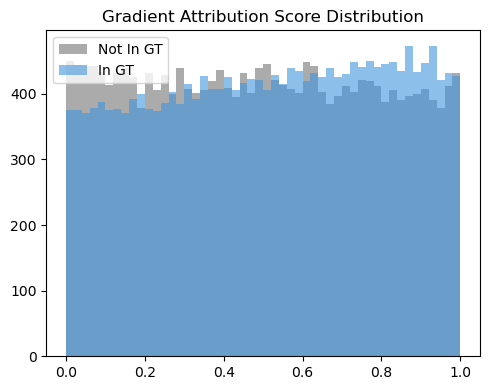

In [647]:
from scipy.stats import rankdata
import numpy as np

def tfwise_rank_normalize(df, score_col, new_col):
    df = df.copy()
    
    df = df[df[score_col] > 0]
    def _rank_to_01(s):
        arr = s.to_numpy(dtype=float)
        if len(arr) == 1:
            # single value ⇒ just put it in the middle
            return np.full_like(arr, 0.5, dtype=float)
        ranks = rankdata(arr, method="average")  # 1..n
        return (ranks - 1) / (len(arr) - 1)      # 0..1

    df[new_col] = df.groupby("tf")[score_col].transform(_rank_to_01)
    return df

for method_name, (df_m, score_col, _, _) in best_results.items():
    df_m = df_m.copy()
    df_norm = tfwise_rank_normalize(df_m, score_col, f"{score_col}_rank")
    
    rank_col = f"{score_col}_rank"
    scores = df_norm[rank_col].astype(float)
    in_gt = scores[df_norm["is_gt"]]
    not_gt = scores[~df_norm["is_gt"]].sample(n=len(in_gt))

    plt.figure(figsize=(5,4))
    plt.hist(not_gt, bins=50, alpha=0.6, color="#747474", label="Not In GT", log=False)
    plt.hist(in_gt, bins=50, alpha=0.6, color="#4195df", label="In GT", log=False)
    plt.title(f"{method_name} Score Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()


- **Ensemble of Gradient Attribution and TF Knockout**
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Gradient Attribution and TF Knockout Best AUROC 0.5630 above quantile 0.060
	- Balanced: 23,627 edges (12,003 pos, 11,624 neg)
	- Balanced: 23,627 edges (12,003 pos, 11,624 neg)


/tmp/ipykernel_3762917/1778483026.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["random_scores"] = create_random_distribution(df[score_col])


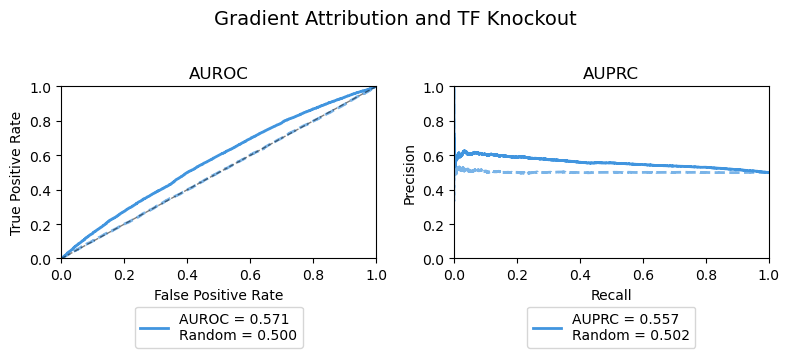

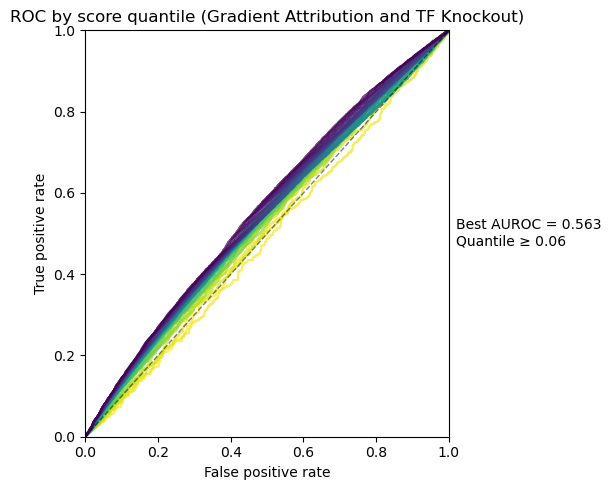

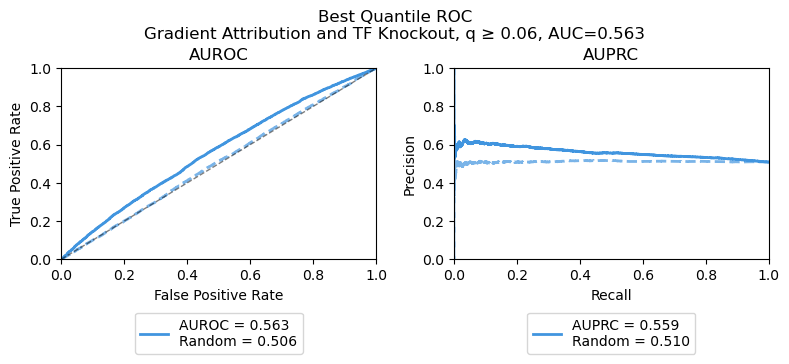

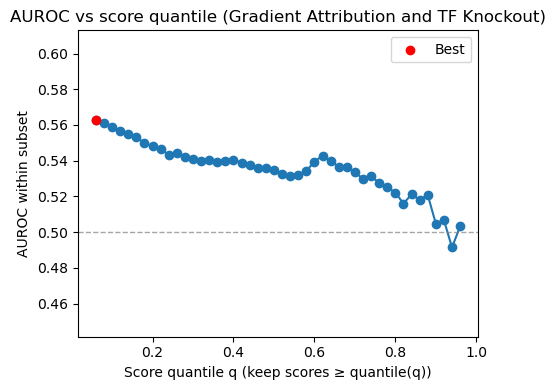

In [648]:
from functools import reduce
from scipy.stats import rankdata
import numpy as np

def tfwise_rank_normalize(df, score_col, new_col):
    """
    Add a TF-wise rank-normalized version of `score_col` in [0,1].
    Does NOT drop any rows; zeros just get low ranks within their TF.
    """
    df = df.copy()

    def _rank_to_01(s):
        arr = s.to_numpy(dtype=float)
        if len(arr) == 1:
            # single edge for this TF → neutral rank
            return np.full_like(arr, 0.5, dtype=float)
        ranks = rankdata(arr, method="average")  # 1..n
        return (ranks - 1) / (len(arr) - 1)      # 0..1

    df[new_col] = df.groupby("tf")[score_col].transform(_rank_to_01)
    return df


df_grad_chip_tf = tfwise_rank_normalize(df_grad_chip_tf, "score_grad_z", "score_grad_rank")
df_ko           = tfwise_rank_normalize(df_ko,           "score_knockout_z", "score_knockout_rank")


# Start from label_df: universe of (tf, tg, is_gt)
df_all = (
    label_df[["tf", "tg", "is_gt"]]
    .merge(df_grad_chip_tf[["tf", "tg", "score_grad_z", "score_grad_rank"]],
           on=["tf", "tg"], how="left")
    .merge(df_ko[["tf", "tg", "score_knockout_z", "score_knockout_rank"]],
           on=["tf", "tg"], how="left")
)

# Only keep edges where both methods have scores
df_all = df_all.dropna(
    subset=["score_grad_z", "score_knockout_z", "score_grad_rank", "score_knockout_rank"]
).reset_index(drop=True)

for col in ["score_grad_z", "score_knockout_z",
            "score_grad_rank", "score_knockout_rank"]:
    m = df_all[col].mean()
    s = df_all[col].std() + 1e-6
    df_all[col + "_std"] = (df_all[col] - m) / s


# simple average ensemble
df_all["score_ensemble_mean"] = (
    df_all["score_grad_rank_std"] +
    df_all["score_knockout_rank_std"]
)

print("- **Ensemble of Gradient Attribution and TF Knockout**")
auc_prc_plot, auroc_ens, auprc_ens = eval_method(
    df_all,
    score_col="score_ensemble_mean",
    name="Gradient Attribution and TF Knockout"
)
auc_prc_plot.show()

fig_roc_ens, fig_auc_ens, fig_best_ens, best_roc, best_q = \
    plot_chiptf_metric_auroc_by_quantile_from_scores(
        df=df_all,
        score_col="score_ensemble_mean",
        metric_name="Gradient Attribution and TF Knockout",
        quantile_step=0.02,
        cmap_name="viridis",
    )

fig_roc_ens.savefig(SELECTED_EXPERIMENT_DIR / "chiptf_ensemble_z_rank_auroc_prc_curves_by_quantile.png", dpi=300)
fig_best_ens.savefig(SELECTED_EXPERIMENT_DIR / "chiptf_ensemble_z_rank_best_roc_curve.png", dpi=300)

fig_roc_ens.show()
fig_auc_ens.show()
fig_best_ens.show()

	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Gradient Attribution Best AUROC 0.5696 above quantile 0.060
	- Balanced: 23,627 edges (12,009 pos, 11,618 neg)
	- Balanced: 23,627 edges (12,009 pos, 11,618 neg)


/tmp/ipykernel_3762917/1778483026.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["random_scores"] = create_random_distribution(df[score_col])


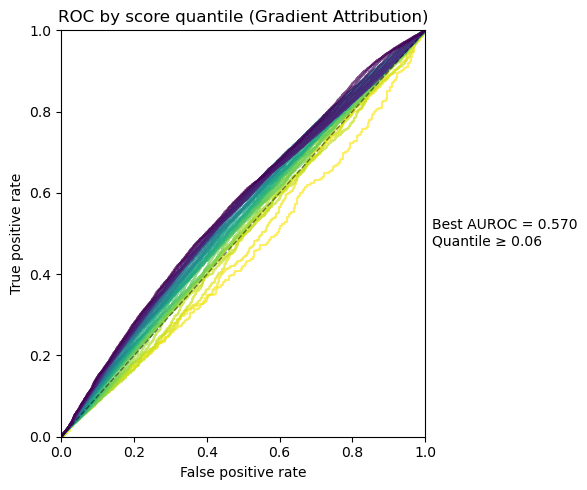

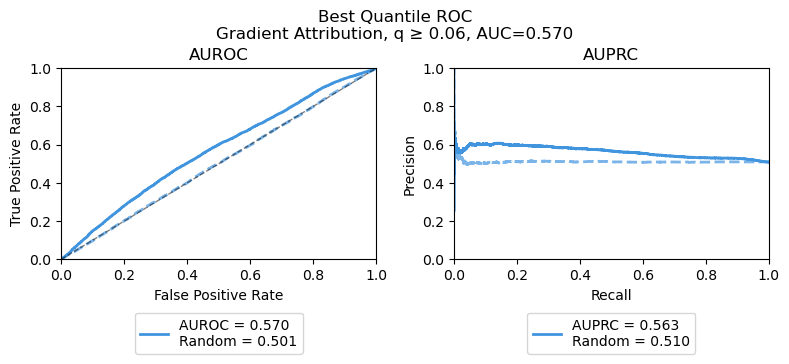

	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- TF Knockout Best AUROC 0.5910 above quantile 0.260
	- Balanced: 18,600 edges (9,359 pos, 9,241 neg)
	- Balanced: 18,600 edges (9,359 pos, 9,241 neg)


/tmp/ipykernel_3762917/1778483026.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["random_scores"] = create_random_distribution(df[score_col])


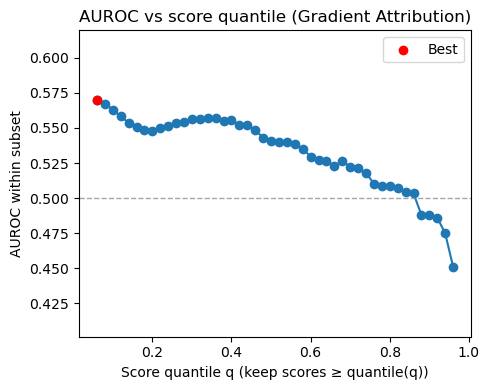

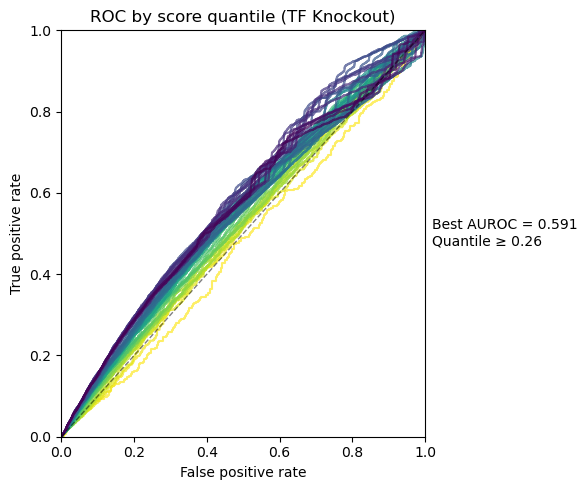

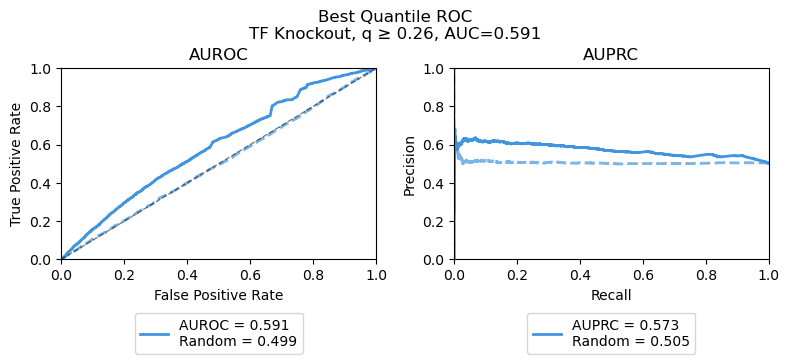

	- Balanced: 25,136 edges (12,568 pos, 12,568 neg)
	- Ensemble Best AUROC 0.5630 above quantile 0.060
	- Balanced: 23,627 edges (12,003 pos, 11,624 neg)
	- Balanced: 23,627 edges (12,003 pos, 11,624 neg)


/tmp/ipykernel_3762917/1778483026.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["random_scores"] = create_random_distribution(df[score_col])


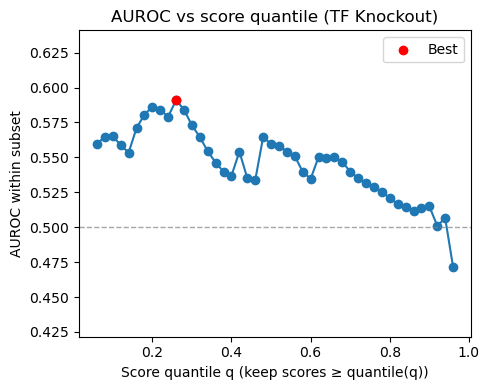

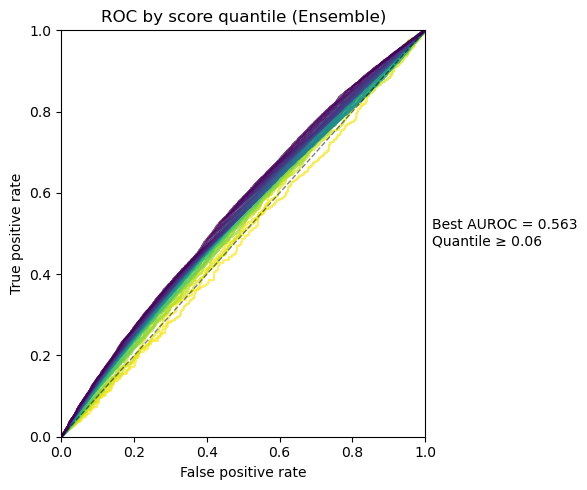

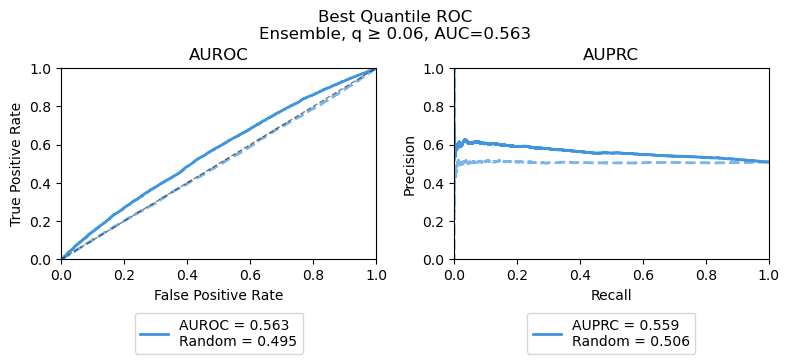

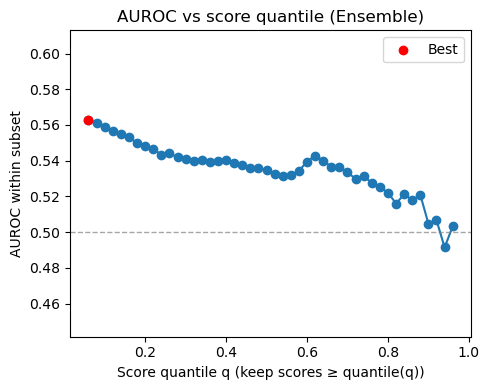

In [649]:
for name, col in [
    ("Gradient Attribution", "score_grad_z"),
    ("TF Knockout", "score_knockout_z"),
    ("Ensemble", "score_ensemble_mean"),
]:  
    fig_roc, fig_auc, fig_best, best_auc, best_q = plot_chiptf_metric_auroc_by_quantile_from_scores(
        df=df_all,
        score_col=col,
        metric_name=name,
        quantile_step=0.02,   # match your previous choice
        cmap_name="viridis",
    )

In [651]:
import numpy as np

def precision_at_k(scores, y, ks):
    order = np.argsort(-scores)
    y_sorted = y[order]
    return {k: y_sorted[:k].mean() for k in ks}

y_all = df_all["is_gt"].astype(int).to_numpy()

scores_grad = df_all["score_grad_z_std"].to_numpy()
scores_ko   = df_all["score_knockout_z_std"].to_numpy()
scores_ens  = df_all["score_ensemble_mean"].to_numpy()  # or scores_lr if you prefer LR

ks = [100, 500, 1000, 5000]

print("Grad P@K:", precision_at_k(scores_grad, y_all, ks))
print("KO   P@K:", precision_at_k(scores_ko,   y_all, ks))
print("Ensemble P@K:", precision_at_k(scores_ens, y_all, ks))


Grad P@K: {100: np.float64(0.25), 500: np.float64(0.28), 1000: np.float64(0.277), 5000: np.float64(0.293)}
KO   P@K: {100: np.float64(0.31), 500: np.float64(0.286), 1000: np.float64(0.317), 5000: np.float64(0.2986)}
Ensemble P@K: {100: np.float64(0.25), 500: np.float64(0.28), 1000: np.float64(0.278), 5000: np.float64(0.295)}


        auroc_ko  auroc_ens
count  40.000000  40.000000
mean    0.568393   0.607767
std     0.052812   0.070560
min     0.494423   0.505939
25%     0.533220   0.559910
50%     0.555927   0.591254
75%     0.596733   0.624545
max     0.720395   0.794463
        tf  auroc_ko  auroc_ens
18   NANOG  0.720395   0.794463
16   MEF2C  0.649625   0.769022
2    ASCL2  0.589049   0.751910
30    SOX9  0.671406   0.747213
21   NR5A2  0.649200   0.718302
25   SALL1  0.504889   0.684444
3     CDX2  0.678983   0.680866
24   RHOX6  0.508684   0.673814
34   TCF12  0.563367   0.631362
23  POU5F1  0.594425   0.629382


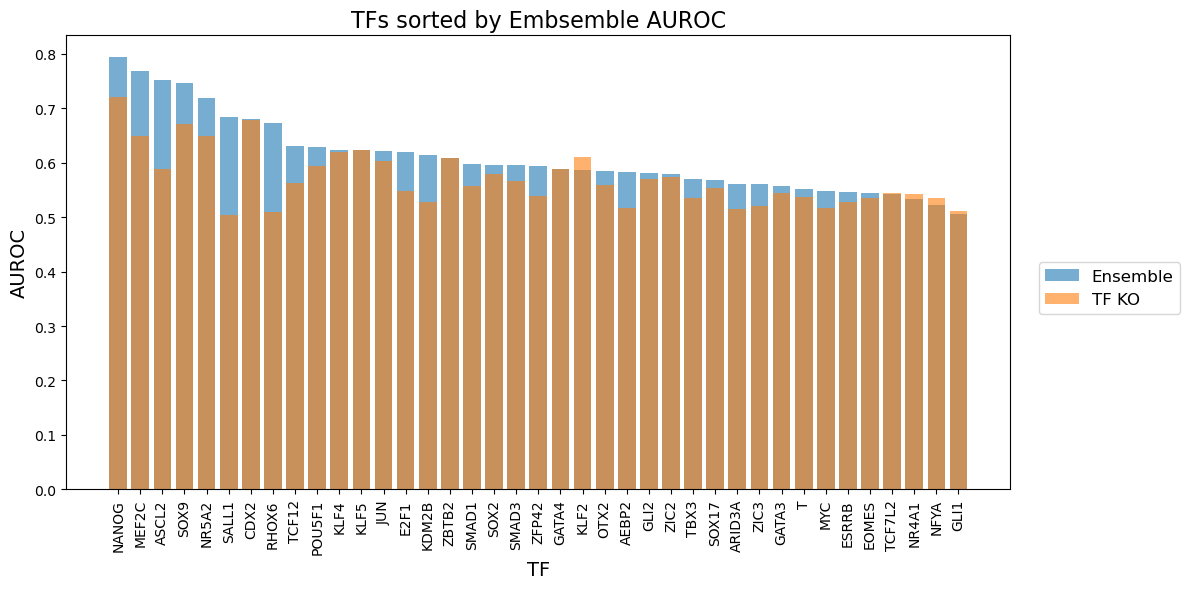

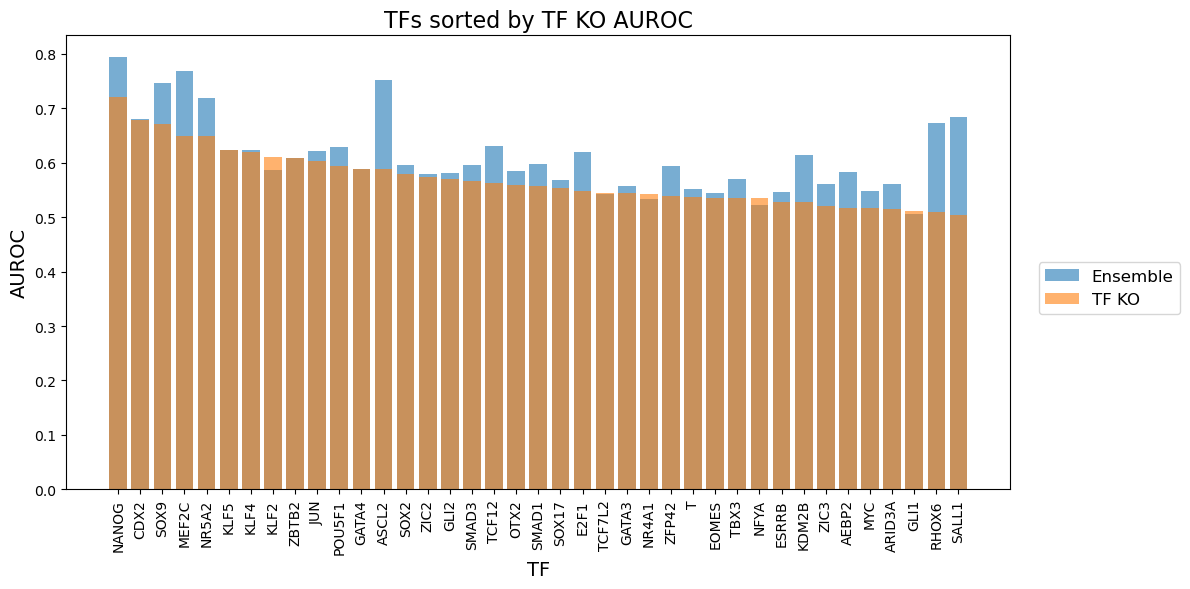

In [652]:
from matplotlib.font_manager import font_scalings
from sklearn.metrics import roc_auc_score
from torch import mul

rows = []
for tf, sub in df_all.groupby("tf"):
    if sub["is_gt"].sum() < 5:  # need at least a few positives
        continue
    y_tf   = sub["is_gt"].astype(int).values
    s_ko   = sub["score_knockout_z_std"].values
    s_ens  = sub["score_ensemble_mean"].values

    rows.append({
        "tf": tf,
        "auroc_ko":  roc_auc_score(y_tf, s_ko),
        "auroc_ens": roc_auc_score(y_tf, s_ens),
    })

per_tf = pd.DataFrame(rows)
print(per_tf.describe())
print(per_tf.sort_values("auroc_ens", ascending=False).head(10))


plt.figure(figsize=(12,6))
per_tf = per_tf.sort_values("auroc_ens", ascending=False)
per_tf = per_tf[per_tf["auroc_ko"] > 0.5]
plt.bar(x="tf", height="auroc_ens", data=per_tf.iloc[:50], width=0.8, alpha=0.6, label="Ensemble")
plt.bar(x="tf", height="auroc_ko", data=per_tf.iloc[:50], width=0.8, alpha=0.6, label="TF KO")
plt.title("TFs sorted by Embsemble AUROC", fontsize=16)
plt.xlabel("TF", fontsize=14)
plt.ylabel("AUROC", fontsize=14)
plt.legend(bbox_to_anchor=(1.03, 0.5), loc="upper left", borderaxespad=0.0, fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
per_tf = per_tf.sort_values("auroc_ko", ascending=False)
per_tf = per_tf[per_tf["auroc_ko"] > 0.5]
plt.bar(x="tf", height="auroc_ens", data=per_tf.iloc[:50], width=0.8, alpha=0.6, label="Ensemble")
plt.bar(x="tf", height="auroc_ko", data=per_tf.iloc[:50], width=0.8, alpha=0.6, label="TF KO")
plt.title("TFs sorted by TF KO AUROC", fontsize=16)
plt.xlabel("TF", fontsize=14)
plt.ylabel("AUROC", fontsize=14)
plt.legend(bbox_to_anchor=(1.03, 0.5), loc="upper left", borderaxespad=0.0, fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()



In [653]:
per_tf["delta"] = per_tf["auroc_ens"] - per_tf["auroc_ko"]
print(per_tf["delta"].describe())
print(per_tf.sort_values("delta", ascending=False).head(15))


count    39.000000
mean      0.039684
std       0.049291
min      -0.022677
25%       0.004290
50%       0.025749
75%       0.066722
max       0.179556
Name: delta, dtype: float64
        tf  auroc_ko  auroc_ens     delta
25   SALL1  0.504889   0.684444  0.179556
24   RHOX6  0.508684   0.673814  0.165129
2    ASCL2  0.589049   0.751910  0.162861
16   MEF2C  0.649625   0.769022  0.119397
12   KDM2B  0.527221   0.614805  0.087585
30    SOX9  0.671406   0.747213  0.075807
18   NANOG  0.720395   0.794463  0.074068
4     E2F1  0.547596   0.619141  0.071544
21   NR5A2  0.649200   0.718302  0.069102
34   TCF12  0.563367   0.631362  0.067995
0    AEBP2  0.517678   0.583127  0.065450
37   ZFP42  0.538543   0.593459  0.054917
1   ARID3A  0.514215   0.561052  0.046836
39    ZIC3  0.521455   0.560656  0.039201
26   SMAD1  0.558260   0.597163  0.038903


In [654]:
sizes = df_all.groupby("tf")["is_gt"].agg(["sum", "count"])
sizes.columns = ["n_pos", "n_total"]
per_tf = per_tf.merge(sizes, left_on="tf", right_index=True)
print(per_tf.sort_values("delta", ascending=False).head(10))


       tf  auroc_ko  auroc_ens     delta  n_pos  n_total
25  SALL1  0.504889   0.684444  0.179556      5     1355
24  RHOX6  0.508684   0.673814  0.165129     18     1355
2   ASCL2  0.589049   0.751910  0.162861    120     1355
16  MEF2C  0.649625   0.769022  0.119397     61     1355
12  KDM2B  0.527221   0.614805  0.087585    918     1355
30   SOX9  0.671406   0.747213  0.075807    214     1355
18  NANOG  0.720395   0.794463  0.074068    620     1355
4    E2F1  0.547596   0.619141  0.071544    354     1355
21  NR5A2  0.649200   0.718302  0.069102     64     1355
34  TCF12  0.563367   0.631362  0.067995    981     1355


In [655]:
tf_of_interest = "FOXO1"
sub = df_all[df_all["tf"] == tf_of_interest].copy()
sub = sub.sort_values("score_ensemble_mean", ascending=False)
top_foxx = sub.head(50)   # top 50 candidate TGs


94th percentile threshold: 2.9325
Top set size:   3,578
Bottom set size:56,042

=== Ensemble @ 94th percentile threshold ===
Overall GT fraction:          0.2108
Top-6% GT fraction:           0.2985
Rest GT fraction:             0.2052
Precision @94% (top set):     0.2985
Recall @94% (top set):        0.0850
Enrichment over baseline:     1.42x

=== Discrimination within top-6% only ===
	- Balanced: 2,136 edges (1,068 pos, 1,068 neg)
	- Balanced: 2,136 edges (1,068 pos, 1,068 neg)
	- Balanced: 2,136 edges (1,068 pos, 1,068 neg)


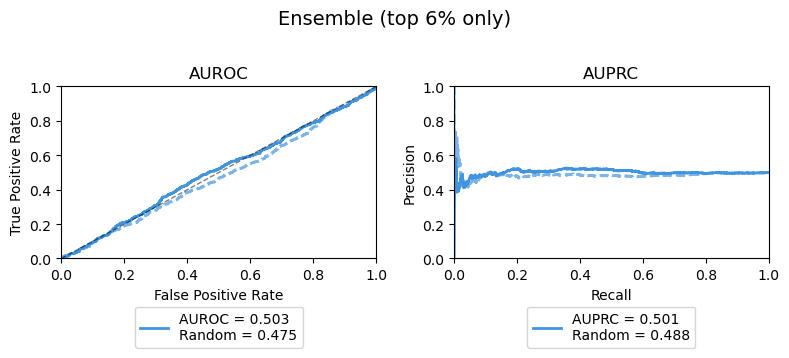

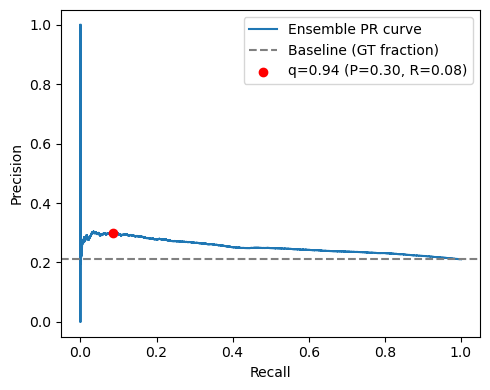

In [656]:
q = 0.94
thr_94 = df_all["score_ensemble_mean"].quantile(q)
print(f"94th percentile threshold: {thr_94:.4f}")

top = df_all[df_all["score_ensemble_mean"] >= thr_94].copy()
rest = df_all[df_all["score_ensemble_mean"] <  thr_94].copy()

print(f"Top set size:   {len(top):,}")
print(f"Bottom set size:{len(rest):,}")

# overall GT stats
gt_total = df_all["is_gt"].sum()
gt_frac_all = df_all["is_gt"].mean()

# top vs rest GT fractions
gt_top = top["is_gt"].sum()
gt_bot = rest["is_gt"].sum()

gt_frac_top = top["is_gt"].mean()
gt_frac_bot = rest["is_gt"].mean()

precision_at_94 = gt_frac_top                    # P(edge is GT | score ≥ thr)
recall_at_94    = gt_top / gt_total             # fraction of all GT edges captured
enrichment_94   = gt_frac_top / (gt_frac_all + 1e-12)

print("\n=== Ensemble @ 94th percentile threshold ===")
print(f"Overall GT fraction:          {gt_frac_all:.4f}")
print(f"Top-6% GT fraction:           {gt_frac_top:.4f}")
print(f"Rest GT fraction:             {gt_frac_bot:.4f}")
print(f"Precision @94% (top set):     {precision_at_94:.4f}")
print(f"Recall @94% (top set):        {recall_at_94:.4f}")
print(f"Enrichment over baseline:     {enrichment_94:.2f}x")

print("\n=== Discrimination within top-6% only ===")
auc_prc_plot, auroc_top, auprc_top = eval_method(
    top,
    score_col="score_ensemble_mean",
    name="Ensemble (top 6% only)"
)

auc_prc_plot.show()

from sklearn.metrics import precision_recall_curve

y_true = df_all["is_gt"].values.astype(int)
scores = df_all["score_ensemble_mean"].values

prec, rec, thr = precision_recall_curve(y_true, scores)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label="Ensemble PR curve")
plt.axhline(y=gt_frac_all, color="gray", linestyle="--", label="Baseline (GT fraction)")

# find closest threshold to 94th percentile
idx_94 = np.argmin(np.abs(thr - thr_94))
plt.scatter(rec[idx_94], prec[idx_94], color="red", zorder=3,
            label=f"q=0.94 (P={prec[idx_94]:.2f}, R={rec[idx_94]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()


In [667]:
tf_ko_df = df_ko.copy()
print(tf_ko_df.head())

      tf             tg  is_gt  score_knockout_z  random_scores  \
0  AEBP2  0610009E02RIK  False         -0.297413       9.191887   
1  AEBP2  1500004A13RIK  False         -0.323307       1.430339   
2  AEBP2  1700003F12RIK   True         -0.323307      11.412142   
3  AEBP2  1700019A02RIK  False         -0.260291      16.788196   
4  AEBP2  1700019D03RIK   True         -0.323307      22.192472   

   score_knockout_rank  
0             0.550222  
1             0.242984  
2             0.242984  
3             0.629985  
4             0.242984  


In [669]:
tf_ko_df = df_ko.copy()

tf_ko_df = tf_ko_df.rename(columns={"tf": "TF", "tg": "TG", "score_knockout_z": "Score"})
tf_ko_df["TF"] = tf_ko_df["TF"].str.capitalize()
tf_ko_df["TG"] = tf_ko_df["TG"].str.capitalize()
tf_ko_df = tf_ko_df[["TF", "TG", "Score"]]
print(tf_ko_df.head())
print(tf_ko_df.shape)

tf_ko_df.to_csv("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/model_classifier_testing/model_tf_ko_best_quantile.csv")

      TF             TG     Score
0  Aebp2  0610009e02rik -0.297413
1  Aebp2  1500004a13rik -0.323307
2  Aebp2  1700003f12rik -0.323307
3  Aebp2  1700019a02rik -0.260291
4  Aebp2  1700019d03rik -0.323307
(59620, 3)
